In [1]:
%cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor

/Users/lchevalier/Dropbox/Project1_N4526/sextractor


In [2]:
import numpy as np
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt
import scipy as sc
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from sklearn import mixture
#from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.mlab as mlab
from cycler import cycler
from numpy import append
%matplotlib inline

/Users/lchevalier/Downloads/Ureka/variants/common/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [989]:

#filename='25_08_16_g_i.fits'
filename='07_11_16_Subaru_HST.fits'
filename1='Subaru_GRI2.fits'
filename2= 'N4526_RVs.fits'
filename3= 'N4526_RV_contamin.fits'
#filename='CFST_match_18_08_16.fits'
hdulist=fits.open(filename)
hdulist1=fits.open(filename1)
hdulist2=fits.open(filename2)
hdulist3=fits.open(filename3)
N4526=hdulist[1].data
Subaru_comp = hdulist1[1].data
RV=hdulist2[1].data
conta=hdulist3[1].data
Apertures=np.arange(1,11,0.5)

cols=hdulist1[1].columns
Imag='MAG_APER_3_10' # used to be 10 ~9 pix in diameter 
Gmag='MAG_APER_1_10'
Rmag='MAG_APER_2_10'

Imag_err='MAGERR_APER_3_10'
Gmag_err='MAGERR_APER_1_10'
Rmag_err='MAGERR_APER_2_10'

IUCD='MAG_APER_3_13'
GUCD='MAG_APER_1_13'
RUCD='MAG_APER_2_13'

IUCD_err='MAGERR_APER_3_13'
GUCD_err='MAGERR_APER_1_13'
RUCD_err='MAGERR_APER_2_13'
#N4526[Rmag]=N4526[Rmag]-0.85
#print cols.names
G=0.084
I=0.046
R=0.061




#APT may no longer be needed if we only use the one aperture instead of 19 or explode colums
#APT=[np.arange(0,N4526['MAG_APER_1_15'].shape[0],1),16]

# Absolute magnitude conversion

N4526[Gmag]=N4526[Gmag]-G
N4526[Rmag]=N4526[Rmag]-R
N4526[Imag]=N4526[Imag]-I

Subaru_comp[Gmag]=Subaru_comp[Gmag]-G
Subaru_comp[Rmag]=Subaru_comp[Rmag]-R
Subaru_comp[Imag]=Subaru_comp[Imag]-I

RV[Gmag]=RV[Gmag]-G
RV[Rmag]=RV[Rmag]-R
RV[Imag]=RV[Imag]-I

conta[Gmag]=conta[Gmag]-G
conta[Rmag]=conta[Rmag]-R
conta[Imag]=conta[Imag]-I

In [990]:
def AB_mag(mag,dist):
    if dist<10**5:
        dist=dist*(10**6)
        #print 'Distance was not entered in pc. And was now converted!!'
    else:
        pass#print ''
    AB= mag - (5*np.log10(dist/10))
    
    return AB

def best_fit(X, Y):
    
    xbar = np.mean(X)#sum(X)/len(X)
    ybar = np.mean(Y)#sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

def diviation(sources):
    x=sources
    lenght= len(sources)
    mean=np.mean(sources)
    standart_dev=(sum((x-mean)**2)/lenght)**0.5
    variance=(sum((x-mean)**2)/lenght)
    
    return standart_dev,variance

def RMS(sources):
    mag= sources
    rms=np.sqrt(np.mean(mag**2))
    
    return rms

def FWHM(sources):
    fwhm=2*np.sqrt(2*np.log(2)*diviation(sources)[0])
    
    return fwhm

def Pritchet_f (mag, mag_0, a ):
    f=0.5 *(1-(a*(mag-mag_0))/(1+(a**2)*(mag-mag_0)**2)**0.5)
    
    return f

def density(Dist):
    dist= np.arange(1,max(Dist),1)
    bins=[]
    #annuli= np.pi*dist**2
    for i in dist:
       bins.append( len(Dist[Dist <= i]))
    return (bins)

def gaussian(x, mu, sig, norm=1):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))*(norm)#/(np.sqrt(np.pi*2)*sig))

def fit_mixture(data, ncomp=2, doplot=False, bins=200):# only fits up to 4 comp at the moment need to change colours o fit more
    clf = mixture.GMM(n_components=ncomp, covariance_type='full', n_iter=100, n_init=10) # different types of covariance ???
    clf.fit(data)
    ml = clf.means_
    wl = clf.weights_
    cl = clf.covars_
    ms = [m[0] for m in ml]
    cs = [np.sqrt(c[0][0]) for c in cl]
    ws = [w for w in wl]
    colours= ['b', 'r', 'g', 'y']
    col =[]
    #print col
    for i in np.arange(0,ncomp,1):
        col.append(colours[i])
    if doplot == True:
        histo = plt.hist(data, bins, normed=True, color='black', histtype='step')
        #plt.rc('axes', prop_cycle=(cycler('color', ['b', 'r', 'g', 'y'])))
        #ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'y']))
        for w, m, c, cl in zip(ws, ms, cs, col):
            plt.plot(histo[1],w*mlab.normpdf(histo[1],m,c), linewidth=3, color = cl)
    return ms, cs, ws #where ms= means cs=covaiance and ws = weights ?!

# 0.3<g-r<0.9
# 0.5<g-i<1.3

cut_gr = [0.3,0.9,0.1,0.1]
cut_gi = [0.5,1.3,0.1,0.1]
cut_ri= [0,0.6]

def Z_gr(gr_range):#all of these need errors on them !! Need a way to incorperate mean errors for g-i and g-r !!
    a,b,a_err,b_err = gr_range
    if (a<b)&(a<0.55)&(b>0.55):
        Zmin= 12.23*a-8.04
        Zmin_err = abs(((2.10/12.23)+(a_err/a))*Zmin+1.01)
        Zmax=5.72*b-4.47
        Zmax_err= abs(((0.20/5.72)+(b_err/b))*Zmax+0.11)
    elif (a>b)&(b<0.55)&(a>0.55):
        Zmin= 12.23*b-8.04
        Zmin_err = abs(((2.10/12.23)+(b_err/b))*Zmin+1.01)
        Zmax=5.72*a-4.47
        Zmax_err= abs(((0.20/5.72)+(a_err/a))*Zmax+0.11)
        
    else: 
        #print 'help'

        
        return Zmin,Zmax, Zmin_err, Zmax_err    

def Z_gi(gi_range):
    a,b,a_err,b_err = gi_range
    if (a<b)&(a<0.77)&(b>0.77):
        Zmin= 7.46*a-7.09
        Zmin_err = abs(((1.28/7.46)+(a_err/a))*Zmin+1.01)
        Zmax=3.49*b-4.03
        Zmax_err= abs(((0.12/3.49)+(b_err/b))*Zmax+0.11)
    elif (a>b)&(b<0.55)&(a>0.55):
        Zmin= 7.46*b-7.09
        Zmin_err = abs(((1.28/7.46)+(b_err/b))*Zmin+1.01)
        Zmax=3.49*a-4.03
        Zmax_err= abs(((0.12/3.49)+(a_err/a))*Zmax+0.11)
        
    else: 
        #print ('help')

        
            return  Zmin,Zmax, Zmin_err, Zmax_err    
    


In [991]:
mag_offset_g= N4526['gamag']-(N4526[Gmag])
rms_offset_g=np.sqrt(np.mean(mag_offset_g**2))

outliers_g=np.where(mag_offset_g>=1)
other_g=np.where(mag_offset_g<=1)
#print mag_offset_g
#print rms_offset_g

mag_offset_i= N4526['zamag']-(N4526[Imag])
rms_offset_i=np.sqrt(np.mean(mag_offset_i**2))

outliers_i=np.where(mag_offset_i>=1)
other_i=np.where(mag_offset_i<=1)
#print mag_offset_i
#print rms_offset_i


#mock points of the 1:1 fit line (same len as GMAG2)
mock_points=np.arange(20,26.1,0.1)
#G_I_APER =subtract(asarray(G_APER),asarray(I_APER))
#G_Z_HST = subtract(asarray(G_gmag),asarray(I_gmag))

#HST_APER = subtract(G_Z_HST,G_I_APER)
#Z_I= subtract(I_gmag,I_APER)

# GDist calculations (in arcmin)

In [992]:
D_RA=N4526['ALPHA_J2000_3']-188.51262
D_DEC=N4526['DELTA_J2000_3']-7.6991162
q=0.43
D_RA_sub=Subaru_comp['ALPHA_J2000_3']-188.51262
D_DEC_sub=Subaru_comp['DELTA_J2000_3']-7.6991162
RV_RA=RV['ALPHA_J2000_3']-188.51262
RV_DEC=RV['DELTA_J2000_3']-7.6991162

Dist= 16.4*(10**6)
GDist= ((D_RA**2+(D_DEC**2))**0.5)*(60**2)
GCD= ((q*D_RA**2+(D_DEC**2)/q)**0.5)*(60**2)
GCD_sub= (q*(D_RA_sub**2+(D_DEC_sub**2)/q)**0.5)*(60**2)
GDist_sub= ((D_RA_sub**2+(D_DEC_sub**2))**0.5)*(60**2)
Dist_RV=((RV_RA**2+(RV_DEC**2))**0.5)*(60**2)
GDist_RV= (q*(RV_RA**2+(RV_DEC**2)/q)**0.5)*(60**2)
#print GDist[GDist<1600]
#GDist_sub= ((q*D_RA_sub**2+(D_DEC_sub**2)/q)**0.5)*(60)

# If colums are not expanded this is how you can get to the specific aperature values for each object

print N4526['MAG_APER_1'][np.arange(0,N4526['MAG_APER_1'].shape[0],1),16]

--> where '16' in the end represents the Aperature size (position thereof
--> bear in mind that python has a different numbering system to topcat etc.... 

In [998]:
selection_comp =(0.25<=(N4526[Gmag]-N4526[Rmag]))&((N4526[Gmag]-N4526[Rmag])<=0.75)&(N4526['zmag']<30)&(N4526['zmag']>0)&(N4526[Imag]<23.5)&(N4526[Imag]>19)&(N4526[Gmag]<30)&(N4526[Gmag]>0)&(N4526[Rmag]<26)&(N4526[Rmag]>0)&(0.45<=(N4526[Gmag]-N4526[Imag]))&(1.3>=(N4526[Gmag]-N4526[Imag]))&(N4526['CLASS_STAR_3']>=0.5)&(N4526['CLASS_STAR_3']>Pritchet_f(N4526[Imag], 24.5, 0.65))&(GDist<=750)#&(N4526['FWHM_IMAGE_3']<=4.1)&((N4526[Rmag]-N4526[Imag])<=0.55)&((N4526[Rmag]-N4526[Imag])>=0.2)#&(GDist<=9.5)
selection_Subaru =(0.25<=(Subaru_comp[Gmag]-Subaru_comp[Rmag]))&((Subaru_comp[Gmag]-Subaru_comp[Rmag])<=0.75)&(Subaru_comp[Imag]<23.5)&(Subaru_comp[Imag]>19)&(Subaru_comp[Gmag]<30)&(Subaru_comp[Gmag]>0)&(Subaru_comp[Rmag]<30)&(Subaru_comp[Rmag]>0)&(0.45<=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&(1.3>=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&(Subaru_comp['CLASS_STAR_3']>=0.5)&(Subaru_comp['CLASS_STAR_3']>Pritchet_f(Subaru_comp[Imag], 24.5, 0.65))&(GDist_sub<=750)#&(Subaru_comp['FWHM_IMAGE_3']<=4.1)&((Subaru_comp[Rmag]-Subaru_comp[Imag])>=0.2)&((Subaru_comp[Rmag]-Subaru_comp[Imag])<=0.55)

selection_RV =(0.25<=(RV[Gmag]-RV[Rmag]))&((RV[Gmag]-RV[Rmag])<=0.75)&(RV[Imag]<23.5)&(RV[Imag]>19)&(RV[Gmag]<30)&(RV[Gmag]>0)&(RV[Rmag]<26)&(RV[Rmag]>0)&(0.45<=(RV[Gmag]-RV[Imag]))&(1.3>=(RV[Gmag]-RV[Imag]))&(RV['CLASS_STAR_3']>=0.5)&(RV['CLASS_STAR_3']>=Pritchet_f(RV[Imag], 24.2, 0.65))&(RV['FWHM_IMAGE_3']<=4.1)&(Dist_RV>=12)&((RV[Rmag]-RV[Imag])<=0.55)&((RV[Rmag]-RV[Imag])>=0.2)
selection_conta =(0.25<=(conta[Gmag]-conta[Rmag]))&((conta[Gmag]-conta[Rmag])<=0.75)&(conta[Imag]<23.5)&(conta[Imag]>19)&(conta[Gmag]<30)&(conta[Gmag]>0)&(conta[Rmag]<26)&(conta[Rmag]>0)&(0.45<=(conta[Gmag]-conta[Imag]))&(1.3>=(conta[Gmag]-conta[Imag]))&(conta['CLASS_STAR_3']>=0.5)&(conta['CLASS_STAR_3']>=Pritchet_f(conta[Imag], 24.2, 0.65))&(conta['FWHM_IMAGE_3']<=4.1)&((conta[Rmag]-conta[Imag])<=0.55)&((conta[Rmag]-conta[Imag])>=0.2)#&(GDist<=9.5)

#############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

UCD_comp=(0.25<=(N4526[GUCD]-N4526[RUCD]))&((N4526[GUCD]-N4526[RUCD])<=0.9)&(N4526['zmag']<30)&(N4526['zmag']>0)&(N4526[IUCD]>17.5)&(N4526[IUCD]<19)&(N4526[GUCD]<30)&(N4526[GUCD]>0)&(N4526[RUCD]<26)&(N4526[RUCD]>0)&(0.45<=(N4526[GUCD]-N4526[IUCD]))&(1.3>=(N4526[GUCD]-N4526[IUCD]))&(N4526['CLASS_STAR_3']>=0.5)&(GDist<=800)&(N4526['FWHM_IMAGE_3']<=4.1)#&((N4526[RUCD]-N4526[IUCD])<=0.55)&((N4526[RUCD]-N4526[IUCD])>=0.2)#&(GDist<=9.5)
UCD_Subaru= (0.25<=(Subaru_comp[GUCD]-Subaru_comp[RUCD]))&((Subaru_comp[GUCD]-Subaru_comp[RUCD])<=0.9)&(Subaru_comp[IUCD]>17.5)&(Subaru_comp[IUCD]<19)&(Subaru_comp[GUCD]<30)&(Subaru_comp[GUCD]>0)&(Subaru_comp[RUCD]<26)&(Subaru_comp[RUCD]>0)&(0.45<=(Subaru_comp[GUCD]-Subaru_comp[IUCD]))&(1.3>=(Subaru_comp[Gmag]-Subaru_comp[IUCD]))&(Subaru_comp['CLASS_STAR_3']>=0.5)&(GDist_sub<=800)&(Subaru_comp['FWHM_IMAGE_3']<=4.1)#&((Subaru_comp[Rmag]-Subaru_comp[IUCD])<=0.55)&((Subaru_comp[Rmag]-Subaru_comp[IUCD])>=0.2)

UCD_RV=(0.25<=(RV[GUCD]-RV[RUCD]))&((RV[GUCD]-RV[RUCD])<=0.9)&(RV[IUCD]>17.5)&(RV[IUCD]<19)&(RV[GUCD]<30)&(RV[GUCD]>0)&(RV[RUCD]<26)&(RV[RUCD]>0)&(0.45<=(RV[GUCD]-RV[IUCD]))&(1.3>=(RV[GUCD]-RV[IUCD]))&(RV['CLASS_STAR_3']>=0.5)&(RV['FWHM_IMAGE_3']<=4.1)#&((RV[RUCD]-RV[IUCD])<=0.55)&((RV[RUCD]-RV[IUCD])>=0.2)
UCD_conta= (0.25<=(conta[GUCD]-conta[RUCD]))&((conta[GUCD]-conta[RUCD])<=0.9)&(conta[IUCD]>17.5)&(conta[IUCD]<19)&(conta[GUCD]<30)&(conta[GUCD]>0)&(conta[RUCD]<26)&(conta[RUCD]>0)&(0.45<=(conta[GUCD]-conta[IUCD]))&(1.3>=(conta[GUCD]-conta[IUCD]))&(conta['CLASS_STAR_3']>=0.5)&(conta['FWHM_IMAGE_3']<=4.1)#&((conta[RUCD]-conta[IUCD])<=0.55)&((conta[RUCD]-conta[IUCD])>=0.2)#&(GDist<=9.5)
#selection_pota = (0.4 <= N4526[Gmag]-N4526[Imag])&(N4526[Gmag]-N4526[Imag] <=1.5)&(0<= N4526[Rmag]-N4526[Imag])&(N4526[Rmag]-N4526[Imag]<=0.6)#& (0.3<=N4526[Gmag]-N4526[Rmag])&(N4526[Gmag]-N4526[Rmag]<=0.9)
#selection =(0.55<=(N4526[Gmag]-N4526[Imag]))&((N4526[Gmag]-N4526[Imag])<=1.8)&(GDist<=45000)&(N4526['CLASS_STAR_1']>=0.45)&(N4526[Rmag]>=20)&(N4526[Rmag]<=26)&((N4526[Rmag]-N4526[Imag])<=2)&((N4526[Rmag]-N4526[Imag])>=0.6)&((N4526[Gmag]-N4526[Rmag])<=0.69)&((N4526[Gmag]-N4526[Rmag])>=-1)#&sel

#  creation of  just candidates file 
# don't rerun unless nececary....

In [999]:
print len(Subaru_comp['DELTA_J2000_3'][selection_Subaru])

ascii.write([Subaru_comp['ALPHA_J2000_3'][selection_Subaru],Subaru_comp['DELTA_J2000_3'][selection_Subaru],Subaru_comp[Imag][selection_Subaru],Subaru_comp[Gmag][selection_Subaru],Subaru_comp[Rmag][selection_Subaru],Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru],GCD_sub[selection_Subaru],GDist_sub[selection_Subaru]],'GC_candidates.cat', names =['#RA','Dec','Imag','Gmag','Rmag','g-i','dist circ', 'Gdist'])

835


# Zeropoint determination and initial filtering

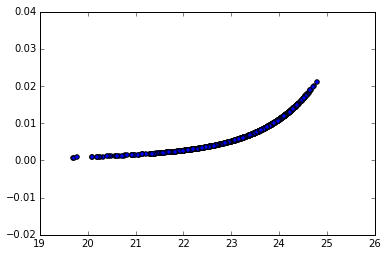

In [1040]:
plt.figure()
plt.scatter(Subaru_comp[Gmag][selection_Subaru],Subaru_comp[Gmag_err][selection_Subaru])
plt.show()

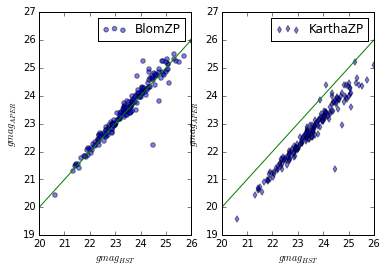

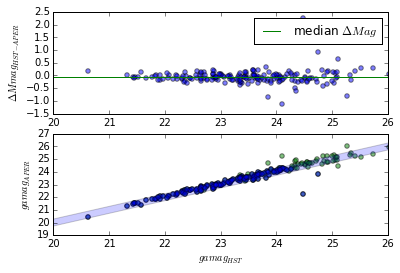

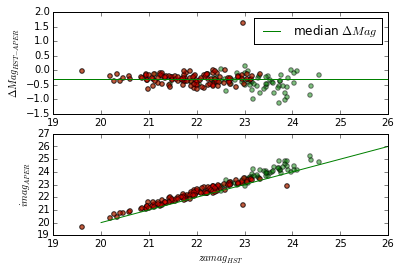

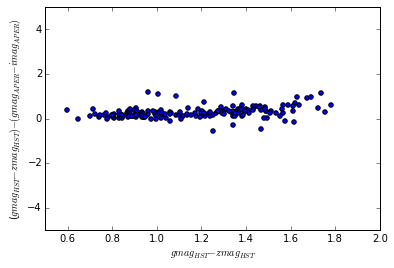

In [1041]:
plt.figure()
plt.subplot(121)

plt.scatter(N4526['gamag'],N4526[Gmag], alpha = 0.5, c='b', label= 'BlomZP')
plt.plot(mock_points,mock_points, c='g')
plt.xlabel('$gmag_{HST}$')
plt.ylabel('$gmag_{APER}$')
plt.xlim(20,26)
plt.legend()

plt.subplot(122)
plt.scatter(N4526['gamag'],N4526[Gmag]-0.86, alpha = 0.5, c='b', label='KarthaZP', marker='d')
plt.plot(mock_points,mock_points, c='g')
plt.xlabel('$gmag_{HST}$')
plt.ylabel('$gmag_{APER}$')
plt.xlim(20,26)
plt.legend()

plt.savefig(filename[:-5]+'_G_zeropints.png')

plt.figure()

plt.subplot(211)
#plt.title('GCs not found in R band')
plt.scatter(N4526['gamag'],mag_offset_g, alpha = 0.5)
plt.axhline(np.median(mag_offset_g) , c='g', label='median $\Delta Mag$')
plt.xlabel('$gmag_{HST}$')
plt.ylabel('$\Delta Mmag_{HST-APER}$')
plt.xlim(20,26)
plt.legend()



plt.subplot(212)
plt.scatter(N4526['gamag'],N4526[Gmag], c='g', alpha=0.5)
#plt.title('GCs not found in R band')
plt.scatter(N4526['gamag'][selection_comp],N4526[Gmag][selection_comp],c='b', alpha = 0.5)

#plt.plot(mock_points,mock_points, c='g')
plt.xlabel('$gamag_{HST}$')
plt.ylabel('$gamag_{APER}$')
plt.xlim(20,26)
plt.legend()
plt.fill_between(mock_points,mock_points-rms_offset_g,mock_points+rms_offset_g, interpolate= True , alpha = 0.2)
plt.savefig(filename[:-5]+'_Gband_offset.png')

plt.figure()

plt.subplot(211)
#plt.title('GCs not found in R band')
plt.scatter(N4526['zamag'],N4526['zamag']-N4526[Imag], alpha = 0.5, c='g')
plt.scatter(N4526['zamag'][selection_comp],N4526['zamag'][selection_comp]-N4526[Imag][selection_comp], alpha = 0.5, c='r')
plt.axhline(np.median(N4526['zamag']-N4526[Imag]), label='median $\Delta Mag$', c='g')
plt.xlabel('$zmag_{HST}$')
plt.ylabel('$\Delta Mag_{HST-APER}$')
plt.xlim(19,26)
plt.legend()

plt.subplot(212)

#plt.title('GCs not found in R band')
plt.scatter(N4526['zamag'],N4526[Imag], alpha = 0.5, c='g')
plt.scatter(N4526['zamag'][selection_comp],N4526[Imag][selection_comp], alpha = 0.5, c='r')
plt.plot(mock_points,mock_points, c='g')
plt.xlabel('$zamag_{HST}$')
plt.ylabel('$imag_{APER}$')
#plt.fill_between(mock_points,mock_points-rms_offset_i,mock_points+rms_offset_i, interpolate= True , alpha = 0.2)
plt.xlim(19,26)
#plt.ylim(18,26)
plt.savefig(filename[:-5]+'_Iband_offset.png')


plt.figure()

plt.scatter(N4526['gmag']-N4526['zmag'],(N4526['gmag']-N4526['zmag'])-(N4526[Gmag]-N4526[Imag]))
#plt.errorbar(G_Z_HST,subtract(G_Z_HST,G_I_APER),yerr=(ERR_G+ERR_i+ERR_g+ERR_z),xerr=(ERR_g+ERR_z),fmt= 'none')
plt.ylabel('($gmag_{HST}-zmag_{HST})-(gmag_{APER}-imag_{APER})$')
plt.xlabel('$gmag_{HST}-zmag_{HST}$')
plt.xlim(0.5,2)
plt.ylim(-5,5)
plt.savefig(filename[:-5]+'_g-z_g-i.png')


plt.show()

# Trunover mag

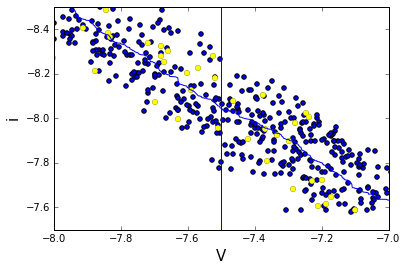

In [910]:
V = Subaru_comp[Gmag][selection_Subaru]-0.34*(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru])-0.03
V_HST = N4526[Gmag][selection_comp]-0.34*(N4526[Gmag][selection_comp]-N4526[Imag][selection_comp])-0.03
plt.figure()
plt.scatter(AB_mag(V,Dist),AB_mag(Subaru_comp[Imag][selection_Subaru],Dist))
plt.scatter(AB_mag(V_HST,Dist),AB_mag(N4526[Imag][selection_comp],Dist), color='yellow')
plt.xlabel('V', size=15)
plt.ylabel('i', size=15)
plt.axvline(-7.5)
plt.xlim(-8,-7)
plt.ylim(-7.5, -8.5)
plt.plot(np.sort(AB_mag(V,Dist)),np.sort(AB_mag(Subaru_comp[Imag][selection_Subaru],Dist)))
plt.show()

# Colour magnitude plots and histograms

21


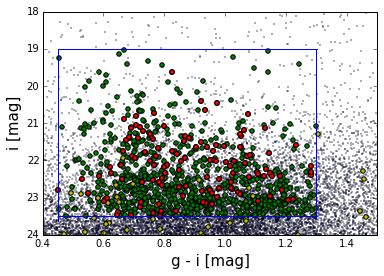

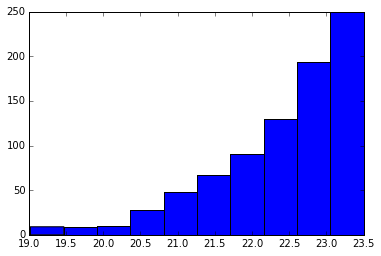

In [911]:
ID=[]
for i in np.arange(0,len(conta['ID']),1):
    #print len(conta['ID'][i])
    if len(conta['ID'][i])<13:
        ID.append('magenta')
    if len(conta['ID'][i])==13:
        ID.append('yellow')
    if len(conta['ID'][i])==14:
        ID.append('yellow')
    if len(conta['ID'][i])==17:
        ID.append('green')
    if len(conta['ID'][i])==16:
        ID.append('green')
        
#plt.scatter(conta[Gmag]-conta[Imag],conta[Imag], c=ID)
print len(conta[Imag][selection_conta])


plt.figure()
plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Imag]),Subaru_comp[Imag], c='b',alpha=0.5, s=0.5, label= 'Subaru_complete')
plt.scatter((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]),Subaru_comp[Imag][selection_Subaru], c='g',label='Subaru_selected')
plt.scatter((N4526[Gmag]-N4526[Imag]),N4526[Imag], c='y',label='HST_matched')
plt.scatter((N4526[Gmag]-N4526[Imag])[selection_comp],N4526[Imag][selection_comp], c='r', label='HST_matched_selected')
#plt.scatter((RV[Gmag]-RV[Imag]),AB_mag(RV[Imag], Dist), c='c',label='RVs')

plt.xlabel('g - i [mag] ', size=15)
plt.ylabel('i [mag]', size=15)
plt.xlim(0.4,1.5)
plt.ylim(24,18)
plt.axvline(0.45, ymin=0.06, ymax=0.83)
plt.axvline(1.3, ymin=0.07, ymax=0.83)
plt.axhline(19,xmin=0.045, xmax=0.82)
plt.axhline(23.5, xmin=0.05,xmax=0.82)           
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_IvsG-I.png')
plt.figure()
plt.hist(Subaru_comp[Imag][selection_Subaru])

plt.show()

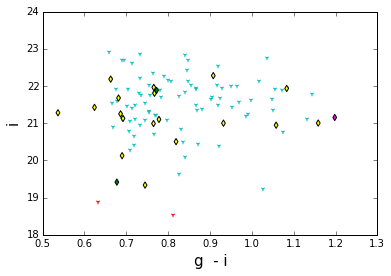

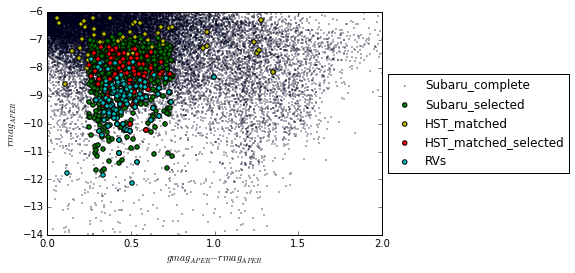

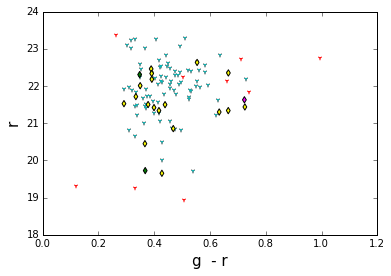

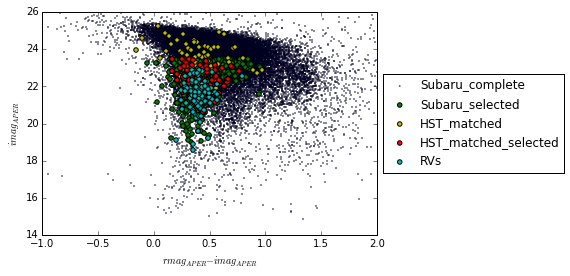

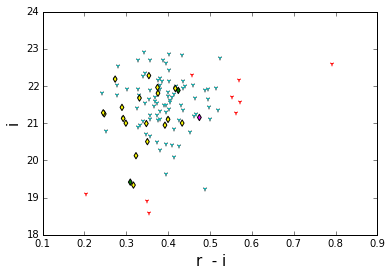

In [912]:
plt.figure()


plt.scatter((RV[GUCD]-RV[IUCD])[UCD_RV],RV[IUCD][UCD_RV], c='r',label='RVs',marker='1')
plt.scatter((RV[Gmag]-RV[Imag])[selection_RV],RV[Imag][selection_RV], c='c',label='RVs',marker='1')
plt.scatter((conta[Gmag]-conta[Imag])[selection_conta],conta[Imag][selection_conta], c=ID,label='contaminants?', marker='d')

plt.xlabel('g  - i ', size=15)
plt.ylabel('i', size=15)
#plt.xlim(0.4,1.5)
#plt.ylim(-6,-15)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_IvsG-I2.png')



plt.figure()
plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Rmag]),AB_mag(Subaru_comp[Rmag],Dist), c='b',alpha=0.5, s=0.5, label= 'Subaru_complete')
plt.scatter((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Rmag][selection_Subaru]),AB_mag(Subaru_comp[Rmag][selection_Subaru],Dist), c='g',label='Subaru_selected')
plt.scatter((N4526[Gmag]-N4526[Rmag]),AB_mag(N4526[Rmag],Dist), c='y', label='HST_matched')
plt.scatter((N4526[Gmag]-N4526[Rmag])[selection_comp],AB_mag(N4526[Rmag][selection_comp],Dist), c='r', label='HST_matched_selected')
plt.scatter((RV[Gmag]-RV[Rmag]),AB_mag(RV[Rmag], Dist), c='c',label='RVs')
plt.xlabel('$gmag_{APER}-rmag_{APER}$')
plt.ylabel('$rmag_{APER}$')
plt.xlim(0,2)
plt.ylim(-14,-6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_RvsG-R.png')

plt.figure()
plt.scatter((RV[Gmag]-RV[Rmag]),RV[Rmag], c='r',label='RVs',marker='1')
plt.scatter((RV[Gmag]-RV[Rmag])[selection_RV],RV[Rmag][selection_RV], c='c',label='RVs',marker='1')
plt.scatter((conta[Gmag]-conta[Rmag])[selection_conta],conta[Rmag][selection_conta], c=ID,label='contaminants', marker='d')

plt.xlabel('g  - r ', size=15)
plt.ylabel('r', size=15)
#plt.xlim(0.4,1.5)
#plt.ylim(-6,-15)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_RvsG-R2.png')

plt.figure()
plt.subplot()
plt.scatter((Subaru_comp[Rmag]-Subaru_comp[Imag]),Subaru_comp[Imag], c='b', alpha=0.5, s=1, label= 'Subaru_complete')
plt.scatter((Subaru_comp[Rmag]-Subaru_comp[Imag])[selection_Subaru],Subaru_comp[Imag][selection_Subaru], c='g', label='Subaru_selected')
plt.scatter((N4526[Rmag]-N4526[Imag]),N4526[Imag], c='y', label='HST_matched')
plt.scatter((N4526[Rmag]-N4526[Imag])[selection_comp],N4526[Imag][selection_comp], c='r', label='HST_matched_selected')
plt.scatter((RV[Rmag]-RV[Imag]),(RV[Imag]), c='c',label='RVs')
plt.xlabel('$rmag_{APER}-imag_{APER}$')
plt.ylabel('$imag_{APER}$')
plt.xlim(-1,2)
plt.ylim(14,26)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_IvsR-I.png')





plt.figure()
plt.scatter((RV[Rmag]-RV[Imag]),RV[Imag], c='r',label='RVs',marker='1')
plt.scatter((RV[Rmag]-RV[Imag])[selection_RV],RV[Imag][selection_RV], c='c',label='RVs',marker='1')
plt.scatter((conta[Rmag]-conta[Imag])[selection_conta],conta[Imag][selection_conta], c=ID,label='contaminats', marker='d')



plt.xlabel('r  - i ', size=15)
plt.ylabel('i', size=15)
#plt.xlim(0.4,1.5)
#plt.ylim(-6,-15)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_IvsR-I2.png')






# Class Star , Ellip, FWHM etc....

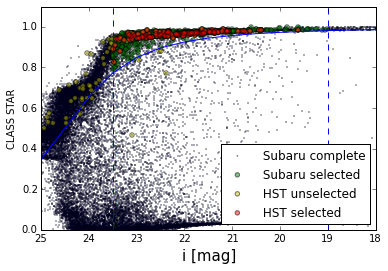

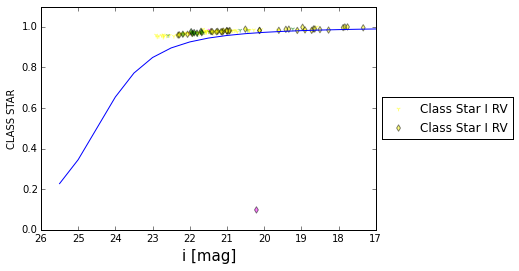

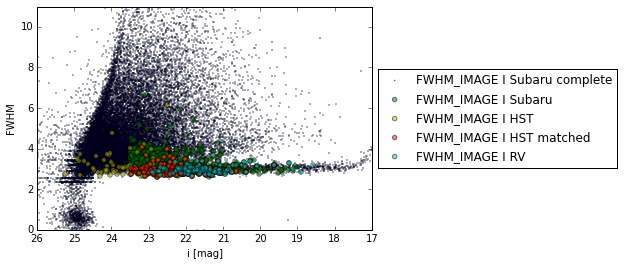

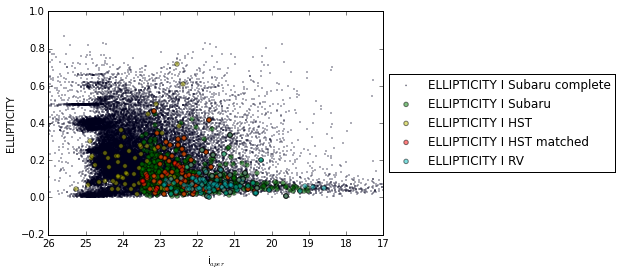

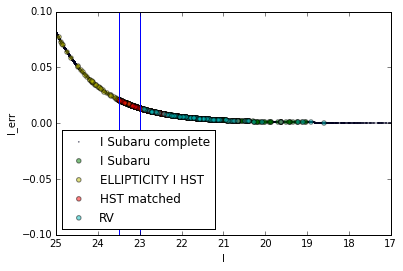

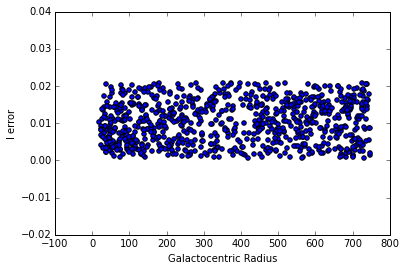

In [913]:

B= np.arange(17,26,0.5)
F=Pritchet_f(B, 24.5, 0.65)

plt.figure()
plt.plot(B,F)
plt.scatter(Subaru_comp[Imag], Subaru_comp['CLASS_STAR_3'], c= 'b', label=' Subaru complete', alpha=0.5, s=0.5)
plt.scatter(Subaru_comp[Imag][selection_Subaru], Subaru_comp['CLASS_STAR_3'][selection_Subaru], c= 'g', label=' Subaru selected', alpha=0.5)
plt.scatter(N4526[Imag], N4526['CLASS_STAR_3'], c= 'y', label=' HST unselected', alpha=0.5)
plt.scatter(N4526[Imag][selection_comp],N4526['CLASS_STAR_3'][selection_comp], c='r',label=' HST selected', alpha=0.5)

#plt.scatter(RV[Imag], RV['CLASS_STAR_3'], c= 'c', label='Class Star I RV', alpha=0.5)

plt.xlabel('i [mag]',size=15)
plt.ylabel('CLASS STAR')
plt.xlim(25,18)
plt.ylim(0,1.1)
plt.legend(loc='lower right', scatterpoints=1)
plt.axvline(19, ls= '--')
plt.axvline(23.5, ls = '--') 
plt.savefig(filename[:-5]+'_classstar.png')
plt.show()

plt.figure()
plt.plot(B,F)

plt.scatter(RV[Imag], RV['CLASS_STAR_3'], c= ID, label='Class Star I RV', alpha=0.5, marker='1')
plt.scatter(conta[Imag], conta['CLASS_STAR_3'], c= ID, label='Class Star I RV', alpha=0.5, marker='d')

plt.xlabel('i [mag]',size=15)
plt.ylabel('CLASS STAR')
plt.xlim(26,17)
plt.ylim(0,1.1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)

plt.show()



plt.figure()
plt.scatter(Subaru_comp[Imag], Subaru_comp['FWHM_IMAGE_3'], c= 'b', label='FWHM_IMAGE I Subaru complete', alpha=0.5, s=0.5)
plt.scatter(Subaru_comp[Imag][selection_Subaru], Subaru_comp['FWHM_IMAGE_3'][selection_Subaru], c= 'g', label='FWHM_IMAGE I Subaru', alpha=0.5)
plt.scatter(N4526[Imag], N4526['FWHM_IMAGE_3'], c= 'y', label='FWHM_IMAGE I HST', alpha=0.5)
plt.scatter(N4526[Imag][selection_comp],N4526['FWHM_IMAGE_3'][selection_comp], c='r',label='FWHM_IMAGE I HST matched', alpha=0.5)

plt.scatter(RV[Imag],RV['FWHM_IMAGE_3'], c= 'c', label='FWHM_IMAGE I RV', alpha=0.5)

plt.xlabel('i [mag]')
plt.ylabel('FWHM')
plt.xlim(26,17)
plt.ylim(0,11)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_FWHM.png')
plt.show()


plt.figure()
plt.scatter(Subaru_comp[Imag], Subaru_comp['ELLIPTICITY_3'], c= 'b', label='ELLIPTICITY I Subaru complete', alpha=0.5, s=0.5)
plt.scatter(Subaru_comp[Imag][selection_Subaru], Subaru_comp['ELLIPTICITY_3'][selection_Subaru], c= 'g', label='ELLIPTICITY I Subaru', alpha=0.5)
plt.scatter(N4526[Imag], N4526['ELLIPTICITY_3'], c= 'y', label='ELLIPTICITY I HST', alpha=0.5)
plt.scatter(N4526[Imag][selection_comp],N4526['ELLIPTICITY_3'][selection_comp], c='r',label='ELLIPTICITY I HST matched', alpha=0.5)

plt.scatter(RV[Imag], RV['ELLIPTICITY_3'], c= 'c', label='ELLIPTICITY I RV', alpha=0.5)

plt.xlabel('i$_{aper}$')
plt.ylabel('ELLIPTICITY')
plt.xlim(26,17)
#plt.ylim(0,11)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_ELLIPTICITY.png')
plt.show()

plt.figure()
plt.scatter(Subaru_comp[Imag], Subaru_comp[Imag_err], c= 'b', label='I Subaru complete', alpha=0.5, s=0.5)
plt.scatter(Subaru_comp[Imag][selection_Subaru], Subaru_comp[Imag_err][selection_Subaru], c= 'g', label='I Subaru', alpha=0.5)
plt.scatter(N4526[Imag], N4526[Imag_err], c= 'y', label='ELLIPTICITY I HST', alpha=0.5)
plt.scatter(N4526[Imag][selection_comp],N4526[Imag_err][selection_comp], c='r',label='HST matched', alpha=0.5)
plt.scatter(RV[Imag], RV[Imag_err], c= 'c', label='RV', alpha=0.5)
plt.axvline(23.5)
plt.axvline(23)
plt.xlabel('I ')
plt.ylabel('I_err')
plt.xlim(25,17)
plt.ylim(-0.1,0.1)
plt.legend(loc='lower left', scatterpoints=1)
plt.savefig(filename[:-5]+'_IerrvsI.png')

plt.figure()
plt.scatter(GDist_sub[selection_Subaru],Subaru_comp[Imag_err][selection_Subaru])
plt.xlabel('Galactocentric Radius')
plt.ylabel('I error')
plt.show()

# Colour Colour diagram

11
11


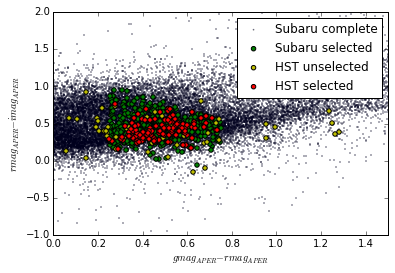

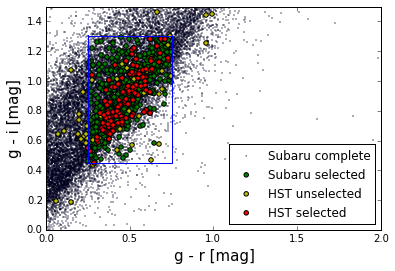

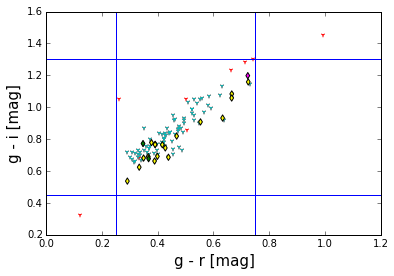

In [914]:
g_i= np.arange(0.25,0.8, (0.75-0.25)/10)
g_r= np.arange(0.45,1.35, (1.3-0.45)/10)

print len(g_i)
print len(g_r)

plt.figure()
plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Rmag]),Subaru_comp[Rmag]-Subaru_comp[Imag], c='b', alpha=0.5, s=0.5, label='Subaru complete')
plt.scatter((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Rmag][selection_Subaru]),Subaru_comp[Rmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru], c='g', label='Subaru selected')
plt.scatter((N4526[Gmag]-N4526[Rmag]),N4526[Rmag]-N4526[Imag], c='y', label='HST unselected')
plt.scatter((N4526[Gmag]-N4526[Rmag])[selection_comp],N4526[Rmag][selection_comp]-N4526[Imag][selection_comp], c='r',label='HST selected')
plt.xlabel('$gmag_{APER}-rmag_{APER}$')
plt.ylabel('$rmag_{APER}-imag_{APER}$')
plt.legend(loc='upper right', scatterpoints=1)#, bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.xlim(0.,1.5)
plt.ylim(-1,2)
plt.savefig(filename[:-5]+'R-IvsG-I_with_outliers.png')


plt.figure()
plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Rmag]),Subaru_comp[Gmag]-Subaru_comp[Imag], c='b', alpha=0.5, s=0.5, label='Subaru complete')
plt.scatter((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Rmag][selection_Subaru]),Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru], c='g', label='Subaru selected')
plt.scatter((N4526[Gmag]-N4526[Rmag]),N4526[Gmag]-N4526[Imag], c='y', label='HST unselected')
plt.scatter((N4526[Gmag]-N4526[Rmag])[selection_comp],N4526[Gmag][selection_comp]-N4526[Imag][selection_comp], c='r',label='HST selected')

#plt.scatter((RV[Gmag]-RV[Rmag]),RV[Gmag]-RV[Imag], c='c', label='RV')

plt.xlabel('g - r [mag]', size=15)
plt.ylabel('g - i [mag]', size=15)
plt.ylim(0.,1.5)
plt.xlim(0,2)

#plt.axhspan(ymin=0.45,ymax=1.3, xmin= 0.25,xmax= 0.75)

plt.axhline(0.45, xmin=0.125, xmax=0.375)
plt.axhline(1.3, xmin=0.125, xmax=0.375)
plt.axvline(0.25,ymin=0.3, ymax=0.875)
plt.axvline(0.75, ymin=0.3,ymax=0.875)
plt.legend(loc='lower right', scatterpoints=1)#, bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'G-RvsG-I_with_outliers.png')



plt.figure()
plt.scatter((RV[Gmag]-RV[Rmag]),RV[Gmag]-RV[Imag], c='r', label='RV',marker='1')
plt.scatter((RV[Gmag]-RV[Rmag])[selection_RV],RV[Gmag][selection_RV]-RV[Imag][selection_RV], c='c', label='RV',marker='1')
plt.scatter((conta[Gmag]-conta[Rmag])[selection_conta],conta[Gmag][selection_conta]-conta[Imag][selection_conta], c=ID,label='contaminats', marker='d')

plt.axhline(0.45)
plt.axhline(1.3)
plt.axvline(0.25)
plt.axvline(0.75)

plt.xlabel('g - r [mag]', size=15)
plt.ylabel('g - i [mag]', size=15)
plt.show()

# Radial velocitys

In [915]:
#print len (RV_RA[blues]), len(RV_DEC[blues])

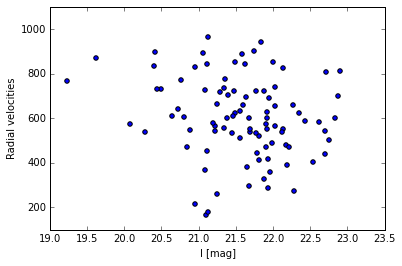

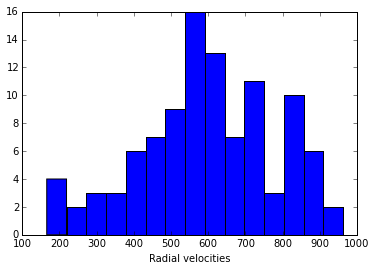

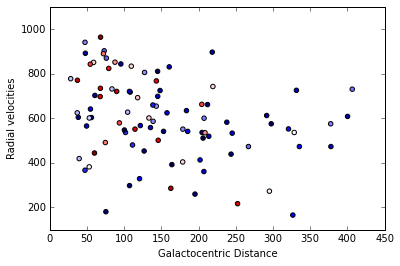

In [916]:
plt.figure()
plt.scatter(RV[Imag][selection_RV],RV['RV'][selection_RV])
plt.xlabel('I [mag]')
plt.ylabel('Radial velocities')
plt.savefig(filename[:-5]+'RVvsI.png')

plt.figure()
plt.hist(RV['RV'], bins=15)
plt.xlabel('Radial velocities')
plt.savefig(filename[:-5]+'RVhist.png')

plt.figure()
plt.scatter(Dist_RV[selection_RV],RV['RV'][selection_RV],c=RV[Gmag][selection_RV]-RV[Imag][selection_RV], cmap='seismic')
plt.ylabel('Radial velocities')
plt.xlabel('Galactocentric Distance')
plt.savefig(filename[:-5]+'RVvsRad.png')

#plt.figure()
#plt.scatter(RV['RAD'][selection_RV],RV['RV'][selection_RV])


plt.show()


# other

0.731928
835
[ 0.4500103   0.48396622  0.51792213  0.55187805  0.58583397  0.61978989
  0.6537458   0.68770172  0.72165764  0.75561356  0.78956947  0.82352539
  0.85748131  0.89143723  0.92539314  0.95934906  0.99330498  1.02726089
  1.06121681  1.09517273  1.12912865  1.16308456  1.19704048  1.2309964
  1.26495232  1.29890823]
2.24328090998


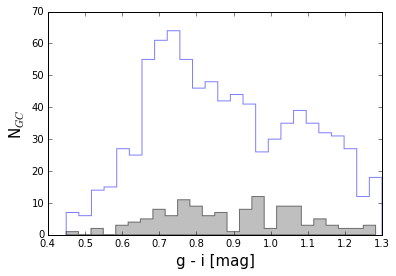

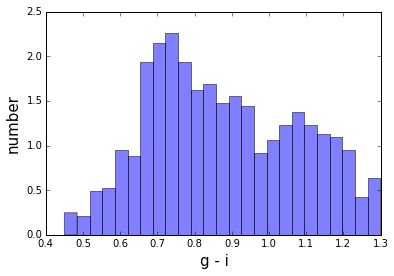

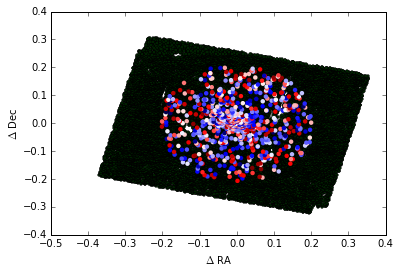

In [917]:
print max((N4526[Gmag]-N4526[Rmag])[selection_comp])

V= Subaru_comp[Gmag][selection_Subaru]*(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Rmag][selection_Subaru])
print len(Subaru_comp[Gmag][selection_Subaru])
#print N4526['CLASS_STAR_2'][selection][86]#, N4526['CLASS_STAR_2'][86]
plt.figure()
plt.hist(AB_mag(Subaru_comp[Gmag][selection_Subaru],16.4)-AB_mag(Subaru_comp[Imag][selection_Subaru],16.4),histtype='step', bins=25, alpha =0.5)
plt.hist((N4526[Gmag]-N4526[Imag])[selection_comp], bins=25, alpha = 0.5, histtype='stepfilled', color='grey')
plt.xlabel('g - i [mag]', size=15)
plt.ylabel('N$_{GC}$', size=15)
plt.savefig(filename[:-5]+'G-Ihist.png')

plt.figure()
n, bins, patches=plt.hist(Subaru_comp[Gmag][selection_Subaru]-(Subaru_comp[Imag][selection_Subaru]), bins=25, alpha =0.5, normed=1)
#plt.hist((N4526[Gmag]-N4526[Imag])[selection_comp], bins=25, alpha = 0.5)
plt.xlabel('g - i', size=15)
plt.ylabel('number', size=15)
bins_blue = bins[0.9>=bins]
mu,sigma =norm.fit((Subaru_comp[Gmag][selection_Subaru]-(Subaru_comp[Imag][selection_Subaru])))
y=mlab.normpdf(bins_blue,mu,sigma)
#l=plt.plot(bins,y,'r--')

print bins
plt.savefig(filename[:-5]+'G-Ihist.png')



plt.figure()
plt.scatter(D_RA_sub,D_DEC_sub, c='g', marker='.')
plt.scatter(D_RA_sub[selection_Subaru],D_DEC_sub[selection_Subaru], c=Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru], cmap='seismic', linewidths=0) # colour them by their g-i values !!!

plt.xlabel('$\Delta$ RA')
plt.ylabel('$\Delta$ Dec')
print FWHM(AB_mag(Subaru_comp[Imag][selection_Subaru], Dist))

#plt.figure()


#plt.figure()
#plt.scatter(AB_mag(V,Dist),AB_mag(Subaru_comp[Imag][selection_Subaru],Dist))
#plt.axvline(-7.5)
#plt.axhline(-8)
#plt.xlim(-8,-7)
#plt.ylim(-10,-6)
plt.show()

(0.026792598863040418, 0.010626351069172313)


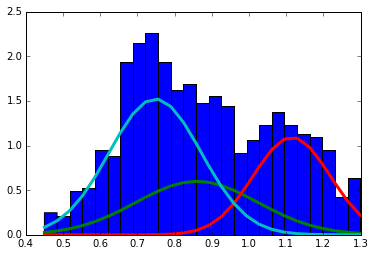

In [918]:
#GMM

data=(Subaru_comp[Gmag][selection_Subaru])-(Subaru_comp[Imag][selection_Subaru])
clf= mixture.GMM(n_components=3, covariance_type='full')
clf.fit(data)
m1, m2, m3 = clf.means_
w1, w2, w3 = clf.weights_
c1, c2, c3 = clf.covars_
print (c1[0][0], c2[0][0])

plt.figure()
histdist = plt.hist(data, 25, normed=True)
plotgauss1 = lambda x: plt.plot(x,w1*mlab.normpdf(x,m1,np.sqrt(c1))[0], linewidth=3)
plotgauss2 = lambda x: plt.plot(x,w2*mlab.normpdf(x,m2,np.sqrt(c2))[0], linewidth=3)
plotgauss3 = lambda x: plt.plot(x,w3*mlab.normpdf(x,m3,np.sqrt(c3))[0], linewidth=3)
plotgauss1(histdist[1])
plotgauss2(histdist[1])
plotgauss3(histdist[1])
plt.show()
#fit_mixture((Subaru_comp[Gmag][selection_Subaru]-(Subaru_comp[Imag][selection_Subaru])), doplot= True, bins=30, ncomp=2)

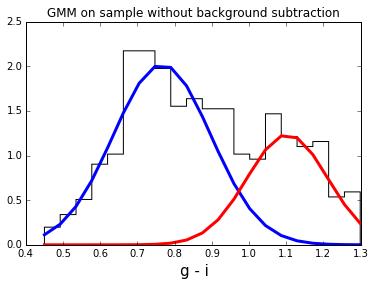

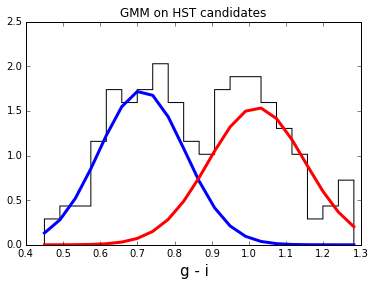

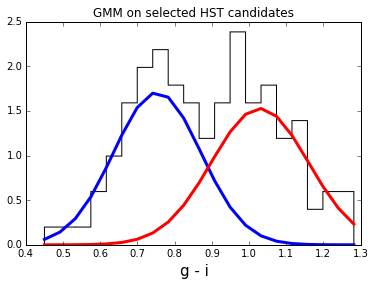

In [919]:
plt.figure()
fit_mixture((Subaru_comp[Gmag][selection_Subaru]-(Subaru_comp[Imag][selection_Subaru])), doplot= True, bins=20, ncomp=2)
plt.title('GMM on sample without background subtraction')
plt.xlabel('g - i', size= 15)


plt.figure()
fit_mixture(N4526[Gmag][((N4526[Gmag]-N4526[Imag])>=0.45)&((N4526[Gmag]-N4526[Imag])<=1.3)]-N4526[Imag][((N4526[Gmag]-N4526[Imag])>=0.45)&((N4526[Gmag]-N4526[Imag])<=1.3)], doplot=True, bins=20, ncomp=2)

plt.title('GMM on HST candidates')
plt.xlabel('g - i', size= 15)
plt.savefig('GMM_HST_comp.png')

plt.figure()
fit_mixture(N4526[Gmag][selection_comp]-N4526[Imag][selection_comp], doplot=True, bins=20, ncomp=2)

plt.title('GMM on selected HST candidates')
plt.xlabel('g - i', size= 15)
plt.savefig('GMM_HST_select.png')
plt.show()

# Outer Annulus

198


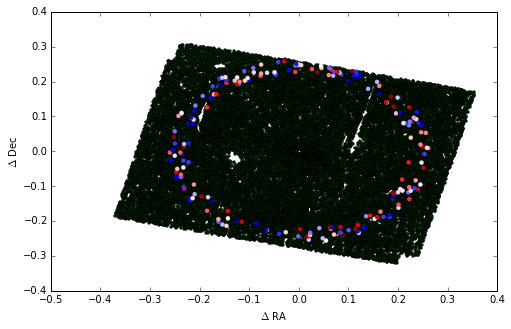

In [920]:

outer_sub=(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)&(0.3<=(Subaru_comp[Gmag]-Subaru_comp[Rmag]))&((Subaru_comp[Gmag]-Subaru_comp[Rmag])<=1)&(Subaru_comp[Imag]<23.5)&(Subaru_comp[Imag]>19)&(Subaru_comp[Gmag]<30)&(Subaru_comp[Gmag]>0)&(Subaru_comp[Rmag]<26)&(Subaru_comp[Rmag]>0)&(0.5<=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&(1.4>=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&((Subaru_comp[Rmag]-Subaru_comp[Imag])<=0.6)&((Subaru_comp[Rmag]-Subaru_comp[Imag])>=0)&(Subaru_comp['CLASS_STAR_3']>=0.5)&(Subaru_comp['CLASS_STAR_3']>Pritchet_f(Subaru_comp[Imag], 24.2, 0.65)) &(GDist_sub>=800)&(GDist_sub<=950)#&(Subaru_comp['FWHM_IMAGE_3']<=4.1)
ra=np.arange(-0.4,0.4,0.02)
ra2=np.arange(0.15,0.4,0.02)
dec=-0.25*ra-0.25
dec2=4.5*ra2-1.25

plt.figure(figsize=(8,5))
plt.scatter(D_RA_sub,D_DEC_sub, c='g', marker='.')
plt.scatter(D_RA_sub[outer_sub],D_DEC_sub[outer_sub], c=Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub], cmap='seismic', linewidths=0) # colour them by their g-i values !!!
#plt.plot(ra,dec)
#plt.plot(ra2,dec2)
print len(D_RA_sub[outer_sub])
plt.xlabel('$\Delta$ RA')
plt.ylabel('$\Delta$ Dec')
plt.savefig('outer_annulus.png')
plt.show()

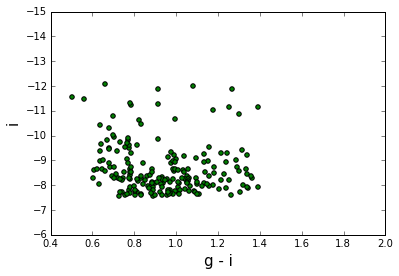

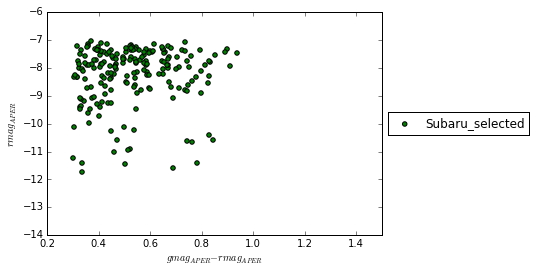

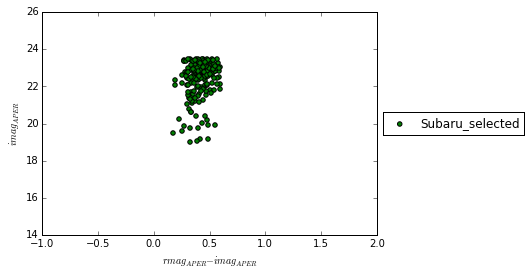

In [921]:
plt.figure()
#print len (Subaru_comp[Gmag][outer_sub])
#plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Imag]),AB_mag(Subaru_comp[Imag],Dist), c='b',alpha=0.5, s=0.5, label= 'Subaru_complete')
plt.scatter((Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub]),AB_mag(Subaru_comp[Imag][outer_sub],Dist), c='g',label='Subaru_selected')
#plt.scatter((N4526[Gmag]-N4526[Imag]),AB_mag(N4526[Imag], Dist), c='y',label='HST_matched')
#plt.scatter((N4526[Gmag]-N4526[Imag])[outer_comp],AB_mag(N4526[Imag][outer_comp], Dist), c='r', label='HST_matched_selected')
#plt.scatter((RV[Gmag]-RV[Imag]),AB_mag(RV[Imag], Dist), c='c',label='RVs')

plt.xlabel('g - i ', size=15)
plt.ylabel('i ', size=15)
plt.xlim(0.4,2)
plt.ylim(-6,-15)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
#plt.savefig(filename[:-5]+'_IvsG-I.png')



plt.figure()
#plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Rmag]),AB_mag(Subaru_comp[Rmag],Dist), c='b',alpha=0.5, s=0.5, label= 'Subaru_complete')
plt.scatter((Subaru_comp[Gmag][outer_sub]-Subaru_comp[Rmag][outer_sub]),AB_mag(Subaru_comp[Rmag][outer_sub],Dist), c='g',label='Subaru_selected')
#plt.scatter((N4526[Gmag]-N4526[Rmag]),AB_mag(N4526[Rmag],Dist), c='y', label='HST_matched')
#plt.scatter((N4526[Gmag]-N4526[Rmag])[outer_comp],AB_mag(N4526[Rmag][outer_comp],Dist), c='r', label='HST_matched_selected')
#plt.scatter((RV[Gmag]-RV[Rmag]),AB_mag(RV[Rmag], Dist), c='c',label='RVs')
plt.xlabel('$gmag_{APER}-rmag_{APER}$')
plt.ylabel('$rmag_{APER}$')
plt.xlim(0.2,1.5)
plt.ylim(-14,-6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
#plt.savefig(filename[:-5]+'_RvsG-R.png')


plt.figure()
plt.subplot()
#plt.scatter((Subaru_comp[Rmag]-Subaru_comp[Imag]),Subaru_comp[Imag], c='b', alpha=0.5, s=1, label= 'Subaru_complete')
plt.scatter((Subaru_comp[Rmag]-Subaru_comp[Imag])[outer_sub],Subaru_comp[Imag][outer_sub], c='g', label='Subaru_selected')
#plt.scatter((N4526[Rmag]-N4526[Imag]),N4526[Imag], c='y', label='HST_matched')
#plt.scatter((N4526[Rmag]-N4526[Imag])[outer_comp],N4526[Imag][outer_comp], c='r', label='HST_matched_selected')
#plt.scatter((RV[Rmag]-RV[Imag]),(RV[Imag]), c='c',label='RVs')
plt.xlabel('$rmag_{APER}-imag_{APER}$')
plt.ylabel('$imag_{APER}$')
plt.xlim(-1,2)
plt.ylim(14,26)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
#plt.savefig(filename[:-5]+'_IvsR-I.png')


plt.show()

964
0.941933
[]


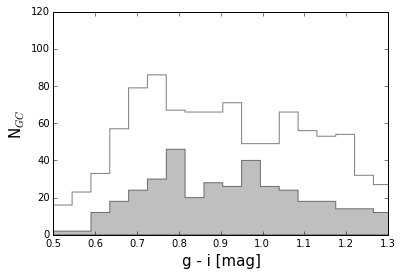

In [1003]:

filename_full='N4526_full_candidates.fits'
hdulist_full=fits.open(filename_full)
full=hdulist_full[1].data
print len(full['g-i'])

bins_back=np.arange(0.5,1.4,0.045)

#plt.figure()
#plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Rmag]),Subaru_comp[Gmag]-Subaru_comp[Imag], c='b', alpha=0.5, s=0.5, label='Subaru complete')
#plt.scatter((Subaru_comp[Gmag][outer_sub]-Subaru_comp[Rmag][outer_sub]),Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub], c='g', label='Subaru selected candidates')
#plt.scatter((N4526[Gmag]-N4526[Rmag]),N4526[Gmag]-N4526[Imag], c='y', label='HST unselected')
#plt.scatter((N4526[Gmag]-N4526[Rmag])[selection_comp],N4526[Gmag][selection_comp]-N4526[Imag][selection_comp], c='r',label='HST selected')

#plt.scatter((RV[Gmag]-RV[Rmag]),RV[Gmag]-RV[Imag], c='c', label='RV')

#plt.xlabel('g - r', size=15)
#plt.ylabel('g - i', size=15)
#plt.ylim(0.,1.5)
#.xlim(0,2)
#.legend(loc='lower right', scatterpoints=1)#, bbox_to_anchor=(1, 0.5), scatterpoints=1)
#plt.savefig(filename[:-5]+'G-RvsG-I_with_outliers.png')


plt.figure()
nb,binsb,patchesb=plt.hist(Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub], bins=bins_back, normed= False,weights=np.round(Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub])*2, alpha= 0.5, histtype='stepfilled', color='grey')
n,bins,patches=plt.hist(full['g-i'], bins=bins_back, normed= False, alpha =0.5, histtype='step', color='black')
interp=sc.interpolate.interp1d(bins_back[:-1], n, assume_sorted=True, kind='cubic')

bin_size=(bins_back[1]-bins_back[0])/2
step=0.0025
new_range=np.arange(0.4,1.3,step)
#trace=interp(new_range)

#plt.plot(new_range+bin_size, trace)
plt.xlabel('g - i [mag]', size=15)
plt.ylabel('N$_{GC}$', size=15)
#plt.plot(bins[:-1],n-nb)
plt.xlim(0.5,1.3)
plt.ylim(0,120)
print (np.mean(Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub]))
#print bins, np.arange(0.5,1.3,0.025)[:-1]

colours_back=[]
for i,b in zip(np.arange(0,len(bins),1),n):
     np.append(colours_back,bins[i])
print (colours_back)
#plt.hist(colours_back,bins=np.arange(0.5,1.3,0.025))
plt.savefig('hist_background.png')
plt.show()

26
[  8  15  20  15  31  41  49  15  28  33  22  22  30  -2  -1  15  25  24
  16  26  16  -1   7 -12  -8]


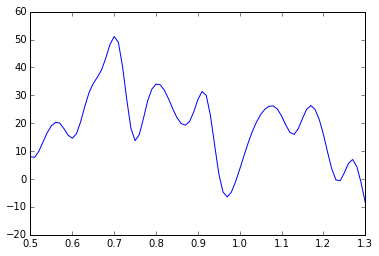

In [1011]:
#bins_back = np.arange(min(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]), max(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]+0.5),0.05)
bins_back=np.arange(0.5,1.4,0.035)
print len(bins_back)
B1= np.digitize((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]),bins_back, right= True)
B2= np.digitize((Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub]),bins_back, right= True)

#print max(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru])
#print (np.bincount(B1, minlength = len(bins_back))-np.bincount(B2,minlength = len(bins_back)))

#bins_back= np.append(bins_back,bins_back[-1:]+0.05)
#print bins_back

#plt.figure()
#plt.plot(bins_back,np.bincount(B1, minlength = len(bins_back))-np.bincount(B2, minlength = len(bins_back)))
#plt.xlim(0.5,1.5)
#plt.show()

A=np.histogram((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]),bins_back)
B=np.histogram((Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub]),bins_back)
background = A[0]-B[0]*2
#print A[0], B[0]
print (background)
#print (bins_back)
inter=sc.interpolate.interp1d(bins_back[:-1], background, assume_sorted=True, kind='cubic')
plt.figure()

x_new= np.arange(0.5,np.max(bins_back[:-1]), 0.01)
y_new=inter(x_new)
plt.figure()
#nb,binsb,patchesb=plt.hist(Subaru_comp[Gmag][outer_sub]-Subaru_comp[Imag][outer_sub], bins=bins_back, normed= False, alpha= 0.5, histtype='stepfilled', color='grey')
#n,bins,patches=plt.hist(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru], bins=bins_back, normed= False, alpha =0.5, histtype='step')
#plt.figure()
#plt.plot(bins[:-1],n-nb)
plt.xlim(0.5,1.3)
#plt.plot(bins_back[:-1], background)
plt.plot(x_new, y_new)

plt.show()

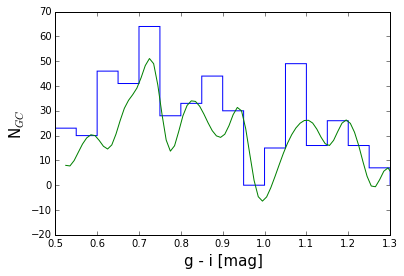

In [1020]:
from numpy import append

bin_size=(bins_back[1]-bins_back[0])/2
BR=[]
for i in np.arange(0,len(bins_back[:-1]),1):
#for c in background[bins_back[:-1]]:
    A= background[i]
    #print background[i]
    #BR.append(A)
    for b in np.arange(0,A,1):
        #print background[i],bins_back[i]
        BR.append(bins_back[i])
    #np.append(BR,bins_back[:-1][i])
#print BR
bins_back_new = np.arange(0.5,1.4,0.05)
bin_size_new=(bins_back_new[1]-bins_back_new[0])/2
plt.figure()
#plt.hist((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]),bins=bins_back[:-1], alpha=0.2, color='yellow', normed=True)
plt.hist(BR,bins=(bins_back_new[:-1]), normed= False, histtype='step')
plt.plot(x_new+bin_size_new, y_new) #plots the general shap eof the histogram
plt.xlabel('g - i [mag]', size=15)
plt.ylabel('N$_{GC}$', size=15)
plt.xlim(0.5,1.3)
plt.savefig('CH_background_removed.png')


#print (BR)

#plt.figure()
#plt.hist((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]),bins=bins_back[:-1], alpha=0.2, color='yellow', normed=True)
#fit_mixture(BR, doplot=True, bins=bins_back[:-1], ncomp=2)
#plt.xlabel('g - i [mag]', size=15)
#plt.ylabel('N$_{GC}$', size=15)
#print (fit_mixture(BR, doplot=False, bins=bins_back[:-1], ncomp=2)[0])
#plt.xlim(0.5,1.3)
#plt.savefig('GMM_background_removed.png')
#plt.axvline(1.116)
#plt.figure()
#.hist((Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]),bins=bins_back[:-1], alpha=0.2, color='yellow',normed=True)
#fit_mixture(BR, doplot=True, bins=bins_back[:-1], ncomp=3)
#plt.plot(np.arange(0.5,1.3,0.05),gaussian(np.arange(0.5,1.3,0.05),0.754,0.124))
#plt.xlabel('g - i [mag]', size=15)
#plt.ylabel('N$_{GC}$', size=15)
#plt.xlim(0.5,1.3)
plt.show()

(0.015780662330486916, 0.0057848945463579984)
[ 0.73564744] [ 1.12125479]


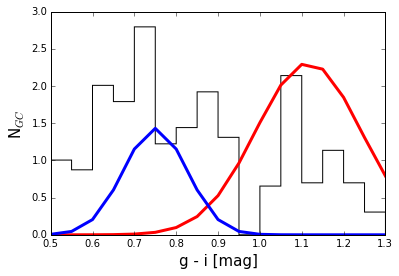

In [1021]:
data= BR#(Subaru_comp[Gmag][selection_Subaru])-(Subaru_comp[Imag][selection_Subaru])
clf= mixture.GMM(n_components=2, covariance_type='full')
clf.fit(data)
m1, m2 = clf.means_
w1, w2 = clf.weights_
c1, c2 = clf.covars_
print (c1[0][0], c2[0][0])
print m1, m2
plt.figure()
histdist = plt.hist(data, bins=bins_back_new[:-1], normed=True, histtype='step', color='black')
plotgauss1 = lambda x: plt.plot(x,w1*mlab.normpdf(x,1.116,np.sqrt(c1))[0], linewidth=3, color='red')
plotgauss2 = lambda x: plt.plot(x,w2*mlab.normpdf(x,0.75,np.sqrt(c2))[0], linewidth=3, color='blue')
#plotgauss3 = lambda x: plt.plot(x,w3*mlab.normpdf(x,m3,np.sqrt(c3))[0], linewidth=3)
plotgauss1(histdist[1])
plotgauss2(histdist[1])
#plotgauss3(histdist[1])
plt.xlabel('g - i [mag]', size=15)
plt.ylabel('N$_{GC}$', size=15)
plt.xlim(0.5,1.3)
plt.savefig('GMM_background_removed.png')
plt.show()

(array([12]),)
(array([5]),)


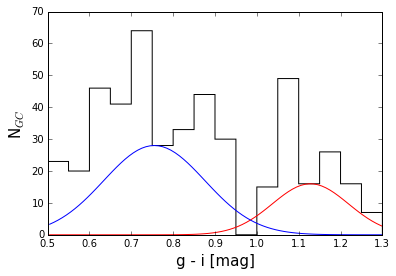

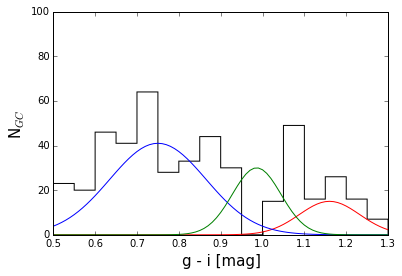

In [1022]:
data= BR
from numpy import where
data2= np.arange(0.5,1.3+0.01,0.01)
print np.where((bins_back_new[:-1]>1.09)&(bins_back_new[:-1]<1.15))
print np.where((bins_back_new[:-1]>0.74)&(bins_back_new[:-1]<0.76))
#print len(histdist[0])
plt.figure()
histdist = plt.hist(data, bins=bins_back_new[:-1], normed=False, histtype='step', color='black')
plt.plot(data2+0.5*(data2[1]-data2[0]),gaussian(data2,1.123,0.091, norm=np.max(histdist[0][12])), color='red')
plt.plot(data2+0.5*(data2[1]-data2[0]),gaussian(data2,0.75,0.121, norm=np.max(histdist[0][5])), color='blue')
plt.xlabel('g - i [mag]', size=15)
plt.ylabel('N$_{GC}$', size=15)
plt.xlim(0.5,1.3)
#plt.ylim(0,100)
plt.savefig('GMM_new.png')

plt.figure()
histdist = plt.hist(data, bins=bins_back_new[:-1], normed=False, histtype='step', color='black')
plt.plot(data2,gaussian(data2,1.16,0.072, norm=np.max(histdist[0][10])), color='red')
plt.plot(data2,gaussian(data2,0.75,0.115, norm=np.max(histdist[0][3])), color='blue')
plt.plot(data2,gaussian(data2,0.986,0.058, norm=np.max(histdist[0][8])), color='green')
plt.xlabel('g - i [mag]', size=15)
plt.ylabel('N$_{GC}$', size=15)
plt.xlim(0.5,1.3)
plt.ylim(0,100)
plt.savefig('GMM_new_trimodal.png')
plt.show()

In [950]:
# making background removed GMM input file -- still needs RV and HST candidates!!
#print data

In [1023]:
ascii.write([data],'background_subtracted_system_full.in')
%mv /Users/lchevalier/Dropbox/Project1_N4526/sextractor/background_subtracted_system_full.in /Users/lchevalier/Desktop/gmm/

# GMM

In [971]:
sel=(0.3<=(Subaru_comp[Gmag]-Subaru_comp[Rmag]))&((Subaru_comp[Gmag]-Subaru_comp[Rmag])<0.9)&(Subaru_comp[Imag]<24)&(Subaru_comp[Imag]>17)&(Subaru_comp[Gmag]<30)&(Subaru_comp[Gmag]>0)&(Subaru_comp[Rmag]<26)&(Subaru_comp[Rmag]>0)&(0.5<=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&(1.3>=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&((Subaru_comp[Rmag]-Subaru_comp[Imag])<=0.6)&((Subaru_comp[Rmag]-Subaru_comp[Imag])>=0)&(Subaru_comp['CLASS_STAR_3']>=0.5)&(Subaru_comp['CLASS_STAR_3']<Pritchet_f(Subaru_comp[Imag], 24.2, 0.7))
sel_bright= (0.3<=(Subaru_comp[Gmag]-Subaru_comp[Rmag]))&((Subaru_comp[Gmag]-Subaru_comp[Rmag])<0.9)&(Subaru_comp[Imag]<24)&(Subaru_comp[Imag]>17)&(Subaru_comp[Gmag]<30)&(Subaru_comp[Gmag]>0)&(Subaru_comp[Rmag]<26)&(Subaru_comp[Rmag]>0)&(0.5<=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&(1.3>=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&((Subaru_comp[Rmag]-Subaru_comp[Imag])<=0.6)&((Subaru_comp[Rmag]-Subaru_comp[Imag])>=0)&(Subaru_comp['CLASS_STAR_3']>=0.5)&(GDist_sub<=10)&(AB_mag(Subaru_comp[Imag],Dist)<=-11)&(AB_mag(Subaru_comp[Imag],Dist)>=-12)#&(Subaru_comp['CLASS_STAR_3']>Pritchet_f(Subaru_comp[Imag], 24.2, 0.7))
Ra, Dec = Subaru_comp['ALPHA_J2000_3'][sel], Subaru_comp['Delta_J2000_3'][sel]
ascii.write([Ra,Dec,Subaru_comp[Imag][sel],Subaru_comp[Gmag][sel]-Subaru_comp[Imag][sel],Subaru_comp['CLASS_STAR_3'][sel]],'positions.in')
A=(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru])
ascii.write([Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]],'colours.in', names=[''])
%mv /Users/lchevalier/Dropbox/Project1_N4526/sextractor/colours.in /Users/lchevalier/Desktop/gmm/

# Bimodal test

In [972]:

%%bash
cd /Users/lchevalier/Desktop/gmm
./gmm colours.in 0 1.1 0.75
cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor


Gaussian Mixture Model of a univariate sample
looking for 2 peaks with different variances
number of data points = 835  kurtosis = -0.917
...running unimodal Gaussian
iter=2 err=0.0e+00:  peak= 0.879 (n=835.0 sig=0.199)  logL1=162.18
...running Gaussian mixture with different variances
iter=128 err=9.8e-07:  peak1= 1.117 (n=259.3 sig=0.093)  peak2= 0.772 (n=575.7 sig=0.129)  logL=214.863
Chi-square statistic (null=unimodal): chi2=105.37 Ndof=4 p=0.00e+00
Peak separation DD = 3.06
...running Gaussian mixture with same variances
iter=27 err=7.7e-07:  peak1= 1.084 (n=323.3 sig=0.114)  peak2= 0.750 (n=511.7 sig=0.114)  logL=212.528
Chi-square statistic (null=unimodal): chi2=100.70 Ndof=2 p=0.00e+00
Peak separation DD = 2.92
...running Gaussian mixture with same means and different variances
iter=20 err=3.6e-07:  peak1= 0.879 (n=570.5 sig=0.199)  peak2= 0.879 (n=264.5 sig=0.199)  logL=162.18
Chi-square statistic (null=equal means): chi2=105.37 Ndof=1 p=0.00e+00
Chi-square statistic (null=eq

In [645]:
%mv /Users/lchevalier/Desktop/gmm/peakprob.out /Users/lchevalier/Dropbox/Project1_N4526/sextractor/

In [ ]:
# background subtracted sample

In [1024]:
%%bash
cd /Users/lchevalier/Desktop/gmm
./gmm background_subtracted_system_full.in 0 1.1 0.75
cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor


Gaussian Mixture Model of a univariate sample
looking for 2 peaks with different variances
number of data points = 458  kurtosis = -1.023
...running unimodal Gaussian
iter=2 err=0.0e+00:  peak= 0.841 (n=458.0 sig=0.204)  logL1=78.5434
...running Gaussian mixture with different variances
iter=11 err=6.6e-07:  peak1= 1.123 (n=124.5 sig=0.066)  peak2= 0.735 (n=333.5 sig=0.121)  logL=145.107
Chi-square statistic (null=unimodal): chi2=133.13 Ndof=4 p=0.00e+00
Peak separation DD = 3.98
...running Gaussian mixture with same variances
iter=30 err=6.9e-07:  peak1= 1.094 (n=146.8 sig=0.104)  peak2= 0.722 (n=311.2 sig=0.104)  logL=131.987
Chi-square statistic (null=unimodal): chi2=106.89 Ndof=2 p=0.00e+00
Peak separation DD = 3.58
...running Gaussian mixture with same means and different variances
iter=15 err=2.5e-07:  peak1= 0.841 (n=190.3 sig=0.204)  peak2= 0.841 (n=267.7 sig=0.204)  logL=78.5434
Chi-square statistic (null=equal means): chi2=133.13 Ndof=1 p=0.00e+00
Chi-square statistic (null=e

In [1025]:
%mv /Users/lchevalier/Desktop/gmm/peakprob.out /Users/lchevalier/Dropbox/Project1_N4526/sextractor/peakprob_full_no_background.out 

# Trimodal Test

In [809]:

%%bash
cd /Users/lchevalier/Desktop/gmm
./gmm colours.in 0 1.1 0.92 0.75
cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor

Gaussian Mixture Model of a univariate sample
looking for 3 peaks with different variances
number of data points = 835  kurtosis = -0.917
...running unimodal Gaussian
iter=2 err=0.0e+00:  peak= 0.879 (n=835.0 sig=0.199)  logL1=162.18
...running Gaussian mixture with different variances
iter=450 err=1.0e-06:  peak1= 1.111 (n=278.0 sig=0.094)  peak2= 0.923 (n=52.2 sig=0.032)  peak3= 0.746 (n=504.7 sig=0.115)  logL=219.132
Chi-square statistic (null=unimodal): chi2=113.90 Ndof=8 p=0.00e+00
Peak separation DD = 2.70
...running Gaussian mixture with same variances
iter=223 err=9.9e-07:  peak1= 1.120 (n=255.0 sig=0.094)  peak2= 0.876 (n=244.1 sig=0.094)  peak3= 0.698 (n=336.0 sig=0.094)  logL=216.198
Chi-square statistic (null=unimodal): chi2=108.04 Ndof=4 p=0.00e+00
Peak separation DD = 2.60
...running Gaussian mixture with same means and different variances
iter=27 err=8.9e-07:  peak1= 0.879 (n=458.1 sig=0.199)  peak2= 0.879 (n= 9.5 sig=0.199)  peak3= 0.879 (n=367.4 sig=0.199)  logL=162.18

In [1026]:
%%bash
cd /Users/lchevalier/Desktop/gmm
./gmm background_subtracted_system_full.in 0 1.2 0.9 0.70
cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor



Gaussian Mixture Model of a univariate sample
looking for 3 peaks with different variances
number of data points = 458  kurtosis = -1.023
...running unimodal Gaussian
iter=2 err=0.0e+00:  peak= 0.841 (n=458.0 sig=0.204)  logL1=78.5434
...running Gaussian mixture with different variances
iter=231 err=9.7e-07:  peak1= 1.120 (n=129.5 sig=0.067)  peak2= 0.873 (n=79.6 sig=0.043)  peak3= 0.685 (n=248.9 sig=0.091)  logL=157.866
Chi-square statistic (null=unimodal): chi2=158.64 Ndof=8 p=0.00e+00
Peak separation DD = 4.39
...running Gaussian mixture with same variances
iter=44 err=8.6e-07:  peak1= 1.120 (n=128.6 sig=0.069)  peak2= 0.837 (n=143.1 sig=0.069)  peak3= 0.651 (n=186.2 sig=0.069)  logL=152.792
Chi-square statistic (null=unimodal): chi2=148.50 Ndof=4 p=0.00e+00
Peak separation DD = 4.08
...running Gaussian mixture with same means and different variances
iter=82 err=8.5e-07:  peak1= 0.838 (n=224.2 sig=0.204)  peak2= 0.838 (n= 0.0 sig=0.051)  peak3= 0.838 (n=233.8 sig=0.204)  logL=78.496

# Make sure the right GMM was run before moving files!!

In [ ]:
#%mv /Users/lchevalier/Desktop/gmm/peakprob.out /Users/lchevalier/Dropbox/Project1_N4526/sextractor/

In [1028]:
f = open('peakprob.out', 'r') # thid file has to be altered so the header with the means is taken out!!
P1=[]#probability of read
P2=[]#probability of blue
for line in f:
    line = line.strip()
    columns = line.split()
    prob = float(columns[0])
    j = float(columns[1])
    i = float(columns[2])
    P1.append(prob)
    P2.append(j)
    print(prob, j, i)
    
print len(P1)
P1= np.array(P1)
P2= np.array(P2)

(0.93, 0.07, 1.09333)
(0.0, 1.0, 0.663759)
(0.202, 0.798, 0.941496)
(0.98, 0.02, 1.15773)
(0.995, 0.005, 1.24166)
(0.819, 0.181, 1.04695)
(0.0, 1.0, 0.706259)
(0.935, 0.065, 1.09712)
(0.0, 1.0, 0.593809)
(0.99, 0.01, 1.20152)
(0.968, 0.032, 1.13229)
(0.952, 0.048, 1.11209)
(0.0, 1.0, 0.624807)
(0.797, 0.203, 1.04118)
(0.771, 0.229, 1.035)
(0.859, 0.141, 1.05919)
(0.061, 0.939, 0.898542)
(0.536, 0.464, 0.994213)
(0.004, 0.996, 0.819477)
(0.0, 1.0, 0.668316)
(0.0, 1.0, 0.700907)
(0.0, 1.0, 0.699005)
(0.145, 0.855, 0.928421)
(0.0, 1.0, 0.661282)
(0.997, 0.003, 1.28042)
(0.004, 0.996, 0.819605)
(0.0, 1.0, 0.669817)
(0.0, 1.0, 0.759283)
(0.997, 0.003, 1.29891)
(0.0, 1.0, 0.675173)
(0.0, 1.0, 0.581068)
(0.018, 0.982, 0.860775)
(0.0, 1.0, 0.728636)
(0.0, 1.0, 0.612303)
(0.0, 1.0, 0.621464)
(0.0, 1.0, 0.700891)
(0.002, 0.998, 0.795664)
(0.129, 0.871, 0.924162)
(0.95, 0.05, 1.10994)
(0.0, 1.0, 0.497612)
(0.995, 0.005, 1.2421)
(0.962, 0.038, 1.1236)
(0.016, 0.984, 0.856909)
(0.91, 0.09, 1.08099)

In [956]:
print sum(1-P1)
print sum(np.round(P1))
print len(P1)
print (P2)
#print len(Subaru_comp[selection_Subaru])

575.732
262.0
835
[ 0.07   1.     0.798  0.02   0.005  0.181  1.     0.065  1.     0.01
  0.032  0.048  1.     0.203  0.229  0.141  0.939  0.464  0.996  1.     1.
  1.     0.855  1.     0.003  0.996  1.     1.     0.003  1.     1.     0.982
  1.     1.     1.     1.     0.998  0.871  0.05   1.     0.005  0.038
  0.984  0.09   1.     0.007  1.     0.993  1.     0.033  0.036  1.     0.94
  0.99   0.966  0.999  0.954  0.016  0.153  0.097  1.     0.073  0.596
  0.013  1.     0.996  1.     1.     1.     1.     0.047  0.998  1.     0.008
  0.614  0.126  0.992  0.003  0.288  0.999  0.142  1.     0.01   1.     0.246
  0.997  0.012  0.583  0.069  1.     0.005  1.     1.     1.     0.983  1.
  1.     0.003  0.997  0.94   0.138  1.     1.     0.579  0.439  0.911  1.
  0.022  0.089  0.055  0.131  1.     0.096  0.999  1.     1.     1.     0.027
  1.     1.     0.029  1.     1.     1.     1.     1.     0.951  1.     1.
  0.996  0.999  0.99   0.028  1.     0.954  1.     0.993  0.062  0.027  1.
  0.00

In [957]:
#Change binning to have equivalent numbers of GCs in each bin 

#Magnitude=GDist_sub[selection_Subaru]
#Blue= Magnitude[(P1<0.5)]
#Red=Magnitude[P1>0.5]
#n=0.5
#bn=1.9992*n -0.3271

# len(Magnitude[(P1<0.6)&(P1>0.4)])
#Background = ((density(Magnitude)[0]/density(Magnitude)[2])**(-bn*((density(Magnitude)[1]/0.75)**(1/n)-1))+0)
#plt.scatter(np.log10(density(Blue)[1]),np.log10(density(Blue)[0]/density(Blue)[2]))
#plt.scatter(np.log10(density(Red)[1]),np.log10(density(Red)[0]/density(Red)[2]), c='r')
#plt.plot(np.log10(density(Magnitude)[1]),np.log10(density(Magnitude)[0]/density(Magnitude)[2]), c='g')
#plt.plot(np.log10(density(Magnitude)[1]),np.log10(Background), c='black')
#plt.xscale('log')
#plt.yscale('log')
#plt.show()

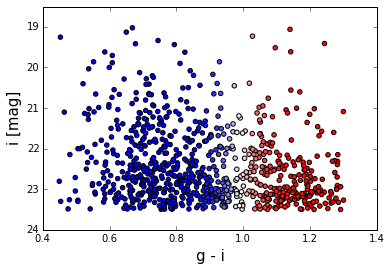

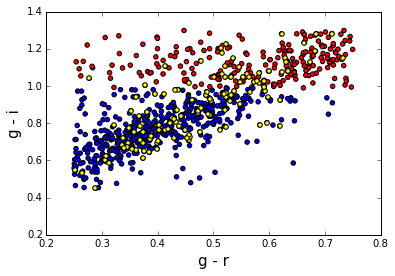

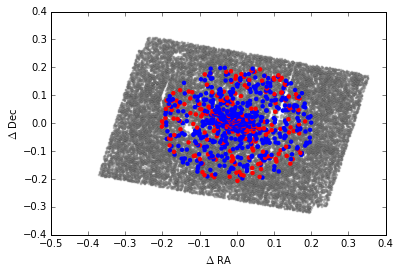

In [958]:
# trial things
blue=(P1)
red=(P2)

plt.figure()
plt.scatter(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru], Subaru_comp[Imag][selection_Subaru], c=P1, cmap='bwr')
plt.ylim(24,18.5)
plt.xlabel('g - i', size=15)
plt.ylabel('i [mag]', size=15)



plt.figure()
plt.scatter(Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Rmag][selection_Subaru], Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru], c=np.round(P1),cmap='bwr')
#plt.ylim(24,18.5)
plt.scatter((N4526[Gmag]-N4526[Rmag])[selection_comp],N4526[Gmag][selection_comp]-N4526[Imag][selection_comp], c='yellow')
plt.xlabel('g - r', size=15)
plt.ylabel('g - i', size=15)
plt.show()

#plt.figure()
#fit_mixture(Subaru_comp[Gmag][selection_Subaru ][blue]-Subaru_comp[Imag][selection_Subaru ][blue], doplot= True, ncomp=1)
#fit_mixture(Subaru_comp[Gmag][selection_Subaru ][red]-Subaru_comp[Imag][selection_Subaru ][red], doplot= True, ncomp=1)


plt.figure()
plt.scatter(D_RA_sub,D_DEC_sub, c='grey', marker='.', alpha =0.5,linewidths=0.1)
plt.scatter(D_RA_sub[selection_Subaru],D_DEC_sub[selection_Subaru], c=np.round(P1), cmap='bwr', linewidths=0) # colour them by their g-i values !!!

plt.xlabel('$\Delta$ RA')
plt.ylabel('$\Delta$ Dec')
plt.show()

# UCD selection

36
0


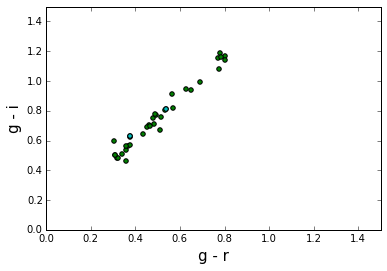

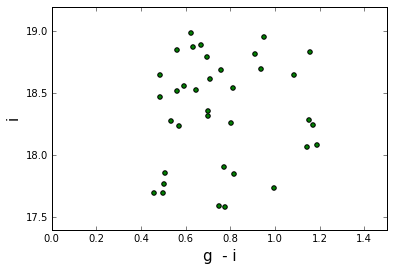

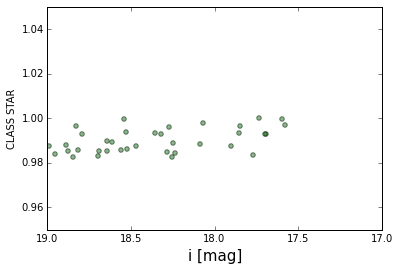

In [959]:
print len(Subaru_comp[GUCD][UCD_Subaru])
print len(N4526[GUCD][UCD_comp])
plt.figure()
#plt.subplot(311)
#plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Rmag]),Subaru_comp[Gmag]-Subaru_comp[Imag], c='b', alpha=0.5, s=0.5, label='Subaru complete')
plt.scatter((Subaru_comp[GUCD][UCD_Subaru]-Subaru_comp[RUCD][UCD_Subaru]),Subaru_comp[GUCD][UCD_Subaru]-Subaru_comp[IUCD][UCD_Subaru], c='g', label='Subaru selected candidates')
#plt.scatter((N4526[Gmag]-N4526[Rmag]),N4526[Gmag]-N4526[Imag], c='y', label='HST unselected')
#plt.scatter((N4526[Gmag]-N4526[Rmag])[selection_comp],N4526[Gmag][selection_comp]-N4526[Imag][selection_comp], c='r',label='HST selected')

plt.scatter((RV[GUCD]-RV[RUCD])[UCD_RV],(RV[GUCD]-RV[IUCD])[UCD_RV], c='c', label='RV', marker ='o')

plt.xlabel('g - r', size=15)
plt.ylabel('g - i', size=15)
plt.ylim(0.,1.5)
plt.xlim(0,1.5)
#plt.legend(loc='lower right', scatterpoints=1)#, bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'G-RvsG-I_UCD.png')

plt.figure()
#plt.scatter((Subaru_comp[Gmag]-Subaru_comp[Imag]),AB_mag(Subaru_comp[Imag],Dist), c='b',alpha=0.5, s=0.5, label= 'Subaru_complete')
plt.scatter((Subaru_comp[GUCD][UCD_Subaru]-Subaru_comp[IUCD][UCD_Subaru]),Subaru_comp[IUCD][UCD_Subaru], c='g',label='Subaru_selected')
#plt.scatter((N4526[Gmag]-N4526[Imag]),AB_mag(N4526[Imag], Dist), c='y',label='HST_matched')
#plt.scatter((N4526[Gmag]-N4526[Imag])[selection_comp],AB_mag(N4526[Imag][selection_comp], Dist), c='r', label='HST_matched_selected')
plt.xlabel('g  - i ', size=15)
plt.ylabel('i', size=15)
plt.xlim(0,1.5)
#plt.ylim(19,15)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_IvsG-I_UCD.png')

plt.figure()
#plt.plot(B,F)
#plt.scatter(Subaru_comp[Imag], Subaru_comp['CLASS_STAR_3'], c= 'b', label='Class Star I Subaru complete', alpha=0.5, s=0.5)
plt.scatter(Subaru_comp[IUCD][UCD_Subaru], Subaru_comp['CLASS_STAR_3'][UCD_Subaru], c= 'g', label='Class Star I Subaru', alpha=0.5)
#plt.scatter(N4526[Imag], N4526['CLASS_STAR_3'], c= 'y', label='Class Star I HST', alpha=0.5)
#plt.scatter(N4526[Imag][selection_comp],N4526['CLASS_STAR_3'][selection_comp], c='r',label='Class Star I HST matched', alpha=0.5)
plt.xlabel('i [mag]',size=15)
plt.ylabel('CLASS STAR')
plt.xlim(19,17)
plt.ylim(0.95,1.05)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1)
plt.savefig(filename[:-5]+'_classstar_UCD.png')
plt.show()


ascii.write([Subaru_comp['ALPHA_J2000_3'][UCD_Subaru],Subaru_comp['DELTA_J2000_3'][UCD_Subaru],Subaru_comp[IUCD][UCD_Subaru]],'UCD.in')

# Completeness

In [960]:
#filename_comp='comp_test_full.fits'
#filename_full='comp_complete_objects.fits'

filename_comp='full_recovered.fits'
filename_full='starlist_full.fits'
#filename='CFST_match_18_08_16.fits'
hdulist_comp=fits.open(filename_comp) #keyword comp for the fake stars recovred
hdulist_full=fits.open(filename_full) #keyword ull for the initial input of fake stars


comp=hdulist_comp[1].data
comp_full= hdulist_full[1].data


In [961]:
band = comp['col1_1']
print len(band[comp['col1_1']=='i'])
print len(band[comp['col1_1']=='r'])

Bins= np.arange(20,28,1)
Bins_G= np.arange(21,28,1)

HST_binned= np.digitize(comp_full['col4'][comp_full['col1']=='i'], Bins)
SSEX_binned= np.digitize(comp['col4_1'][comp['col1_1']=='i'],Bins)

#print sum(SSEX_R_B)

24292
23769


In [962]:
Bins= np.arange(15,26,0.25)


HST_binned= np.digitize(comp_full['col4'][comp_full['col1']=='i'], Bins)
SSEX_binned= np.digitize(comp['col4_1'][comp['col1_1']=='i'],Bins)

HST_G_binned= np.digitize(comp_full['col4'][comp_full['col1']=='g'], Bins)
SSEX_G_binned= np.digitize(comp['col4_1'][comp['col1_1']=='g'],Bins)

HST_R_binned= np.digitize(comp_full['col4'][comp_full['col1']=='r'], Bins)
SSEX_R_binned= np.digitize(comp['col4_1'][comp['col1_1']=='r'],Bins)


HST_B = np.bincount(HST_binned)
SSEX_B = np.bincount(SSEX_binned)



if (len(HST_B)>len(SSEX_B)):
    SSEX_B=np.insert(SSEX_B,len(SSEX_B),0)
    if (len(HST_B)>len(SSEX_B)):
        SSEX_B=np.insert(SSEX_B,len(SSEX_B),0)
else:
    print 'has the right shape'

    
    
    
HST_G_B = np.bincount(HST_G_binned)
SSEX_G_B = np.bincount(SSEX_G_binned)


HST_R_B = np.bincount(HST_R_binned)
SSEX_R_B = np.bincount(SSEX_R_binned)




if (len(HST_G_B)>len(SSEX_G_B)):
    SSEX_G_B=np.insert(SSEX_G_B,len(SSEX_G_B),0)
    if (len(HST_G_B)>len(SSEX_G_B)):
        SSEX_G_B=np.insert(SSEX_G_B,len(SSEX_G_B),0)
else:
    print 'should be the right length \n\n'

if (len(HST_R_B)>len(SSEX_R_B)):
    SSEX_R_B=np.insert(SSEX_R_B,len(SSEX_R_B),0)
    if (len(HST_R_B)>len(SSEX_R_B)):
        SSEX_R_B=np.insert(SSEX_R_B,len(SSEX_R_B),0)
else:
    print 'should be the right length \n\n'




print 'HST objects:',HST_B
print 'I band SUBARU',SSEX_B
print ' \n'
print 'HST objects:',HST_G_B
print 'G band SUBARU',SSEX_G_B
print ' \n'
print 'HST objects:',HST_R_B
print 'R band SUBARU',SSEX_R_B

has the right shape
should be the right length 


should be the right length 


HST objects: [   0    0    0    0    0  706  703  695  716  633  633  692  684  677  689
  699  667  681  671  678  727  662  665  657  717  694  652  664  685  670
  687  673  675  742  723  717  696  708  662  642  655  688  671  684 3360]
I band SUBARU [  0   0   0   0   0 706 702 694 714 631 632 692 683 677 688 694 662 679
 666 675 726 659 659 652 710 687 649 653 675 660 683 663 651 718 700 682
 656 671 614 579 445 187  38  17  63]
 

HST objects: [   0    0    0    0    0  895  924  931  893  929  916  894  886  917  906
  916  903  897  927  927  895  834  922  888  970  891  896  919  969  962
  864  917  903  950  962  912  928  889  950  871  909  940  876  852 4470]
G band SUBARU [  0   0   0   0   0 895 922 928 893 927 915 891 884 913 904 914 892 889
 920 923 891 827 914 883 963 879 884 908 946 944 852 896 880 915 907 861
 859 823 854 788 787 803 720 488 252]
 

HST objects: [   0    0    0    0 

/Users/lchevalier/Downloads/Ureka/variants/common/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/lchevalier/Downloads/Ureka/variants/common/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/Users/lchevalier/Downloads/Ureka/variants/common/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


[        nan         nan         nan         nan  1.          0.99857752
  0.99856115  0.9972067   0.99684044  0.99842022  1.          0.99853801
  1.          0.99854862  0.99284692  0.99250375  0.99706314  0.99254844
  0.99557522  0.99862448  0.99546828  0.99097744  0.99238965  0.9902371
  0.98991354  0.99539877  0.98343373  0.98540146  0.98507463  0.99417758
  0.98514116  0.96444444  0.96765499  0.96818811  0.9511855   0.94252874
  0.94774011  0.92749245  0.90186916  0.67938931  0.27180233  0.05663189
  0.0248538   0.01875   ]


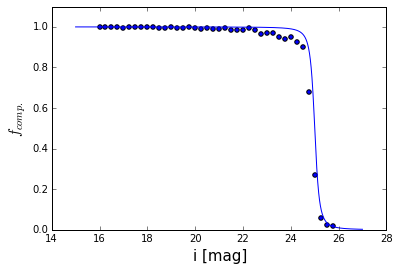

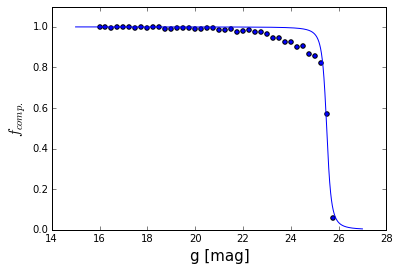

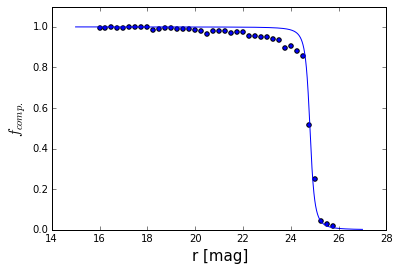

0.167947948153 0.227314427888 0.21186669328


In [963]:
completeness_frac=np.true_divide(SSEX_B,HST_B)
print completeness_frac[1:]

if len(Bins)<len(completeness_frac):
    Bins=np.insert(Bins,0,min(comp['col4_1'][comp['col1_1']=='i']))
    
if len(Bins)>len(completeness_frac):
    completeness_frac=np.insert(completeness_frac,len(completeness_frac),0)
    
completeness_frac_G=np.true_divide(SSEX_G_B,HST_G_B)

if len(Bins_G)<len(completeness_frac_G):
    Bins_G=np.insert(Bins_G,0,min(comp['col4_1'][comp['col1_1']=='g']))
    
completeness_frac_R=np.true_divide(SSEX_R_B,HST_R_B)

if len(Bins_G)<len(completeness_frac_R):
    Bins_G=np.insert(Bins_G,0,min(comp['col4_1'][comp['col1_1']=='r']))
    
    
    
    
P_points = np.arange(15,27,0.005)

    
plt.figure()

plt.scatter(Bins[1:], completeness_frac[1:])
plt.xlabel('i [mag]', size=15)
plt.ylabel('$f_{comp.}$', size=15)
plt.ylim(0,1.1)

plt.plot(P_points, Pritchet_f(P_points,25,5))
plt.savefig(filename_comp[:-5]+'_Mag_completeness_I.png')


plt.figure()

plt.scatter(Bins, completeness_frac_G)
plt.xlabel('g [mag]', size=15)
plt.ylabel('$f_{comp.}$', size=15)
plt.ylim(0,1.1)
plt.plot(P_points, Pritchet_f(P_points,25.5,5))
plt.savefig(filename_comp[:-5]+'_Mag_completeness_G.png')

#plt.figure()
#plt.hist(completeness_frac)

plt.figure()

plt.scatter(Bins, completeness_frac_R)
plt.xlabel('r [mag]', size=15)
plt.ylabel('$f_{comp.}$', size=15)
plt.ylim(0,1.1)
plt.plot(P_points, Pritchet_f(P_points,24.8,5))
plt.savefig(filename_comp[:-5]+'_Mag_completeness_R.png')

#plt.figure()
#plt.hist(completeness_frac)
plt.show()


XXXG = np.true_divide(np.nansum(completeness_frac_G), len(completeness_frac_G))
XXXR = np.true_divide(np.nansum(completeness_frac_R), len(completeness_frac_R))
XXXI= np.true_divide(np.nansum(completeness_frac), len(completeness_frac))

print 1-XXXG, 1-XXXR, 1-XXXI

[    1.41630833    85.86280145   119.56317492   147.58757263   170.28140055
   189.39867159   206.59321101   223.80558388   239.98078966   255.63936081
   271.9737566    292.89485865   315.35214672   346.98017604   488.82096144
   711.74111627   891.55934095  1031.59682603  1164.95786467  1316.57320038]
has the right shape
has the right shape
has the right shape
#### g ####
[ 599 1143 1119 1097 1123 1148 1146  850 1086 1080 1242 1064 1131  732]
[ 589 1142 1118 1094 1122 1145 1143  844 1081 1074 1236 1061 1125  731]
#### r ####
[ 526 1145 1101 1087 1059 1043 1099  632  497  555  601  570  552  376]
[ 509 1145 1101 1086 1055 1039 1096  625  486  548  600  567  548  375]
#### i ####
[ 533 1129 1112 1085 1103 1069 1121  549  551  534  623  557  575  411]
[ 523 1127 1112 1085 1102 1069 1119  546  545  532  621  555  575  411]


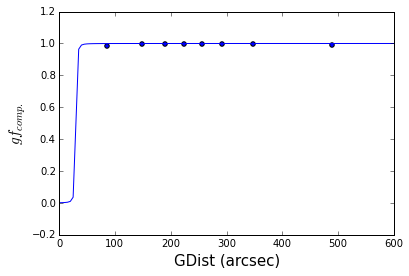

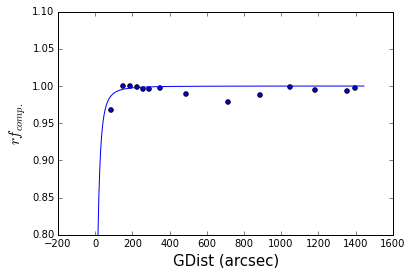

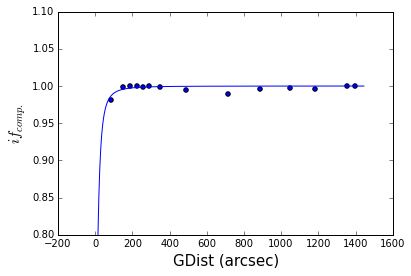

In [1065]:
D_RA=comp['col2_1'][(comp['col1_1']=='g')&(comp['col4_1']<=20)&(comp['col4_1']>=16)]-6288.1837
D_DEC=comp['col3_1'][(comp['col1_1']=='g')&(comp['col4_1']<=20)&(comp['col4_1']>=16)]-5775.7879

D_RA_r=comp['col2_1'][(comp['col1_1']=='r')&(comp['col4_1']<=20)&(comp['col4_1']>=16)]-6281.2293
D_DEC_r=comp['col3_1'][(comp['col1_1']=='r')&(comp['col4_1']<=20)&(comp['col4_1']>=16)]-5743.8101

D_RA_i=comp['col2_1'][(comp['col1_1']=='i')&(comp['col4_1']<=20)&(comp['col4_1']>=16)]-6290.1076
D_DEC_i=comp['col3_1'][(comp['col1_1']=='i')&(comp['col4_1']<=20)&(comp['col4_1']>=16)]-5785.2218

D_HST_RA_g=comp_full['col2'][(comp_full['col1']=='g')&(comp_full['col4']<=20)&(comp_full['col4']>=16)]-6288.1837
D_HST_DEC_g=comp_full['col3'][(comp_full['col1']=='g')&(comp_full['col4']<=20)&(comp_full['col4']>=16)]-5775.7879

D_HST_RA_r=comp_full['col2'][(comp_full['col1']=='r')&(comp_full['col4']<=20)&(comp_full['col4']>=16)]-6281.2293
D_HST_DEC_r=comp_full['col3'][(comp_full['col1']=='r')&(comp_full['col4']<=20)&(comp_full['col4']>=16)]-5743.8101

D_HST_RA_i=comp_full['col2'][(comp_full['col1']=='i')&(comp_full['col4']<=20)&(comp_full['col4']>=16)]-6290.1076
D_HST_DEC_i=comp_full['col3'][(comp_full['col1']=='i')&(comp_full['col4']<=20)&(comp_full['col4']>=16)]-5785.2218


GDist= ((D_RA**2+D_DEC**2)**0.5)*(0.2)
GDist_r= ((D_RA_r**2+D_DEC_r**2)**0.5)*(0.2)
GDist_i= ((D_RA_i**2+D_DEC_i**2)**0.5)*(0.2)
GDist_HST_g= (((D_HST_RA_g)**2+(D_HST_DEC_g)**2)**0.5)*(0.2)
GDist_HST_r= (((D_HST_RA_r)**2+(D_HST_DEC_r)**2)**0.5)*(0.2)
GDist_HST_i= (((D_HST_RA_i)**2+(D_HST_DEC_i)**2)**0.5)*(0.2)

manual_distances = [85,148,190,224,255.8,292,347,489,711.6,888,1046,1181,1353.5]

distances = manual_distances#np.sort(GDist_HST_g)[0::550]
distances_r = manual_distances#np.sort(GDist_HST_r)[0::550]
distances_i = manual_distances#np.sort(GDist_HST_i)[0::550] # in this case HST describes the full sample of added objects on the subaru image



#Bins_Dist= np.arange(0,1500,50)
Bins_Dist= np.round(distances)
Bins_Dist_r= np.round(distances_r)
Bins_Dist_i= np.round(distances_i)

print np.sort(GDist_HST_i)[0::550]

HST_DB= np.digitize(GDist_HST_g, Bins_Dist)
SSEX_DB= np.digitize(GDist,Bins_Dist)

HST_Dist = np.bincount(HST_DB)
SSEX_Dist = np.bincount(SSEX_DB)

###############
HST_DB_r= np.digitize(GDist_HST_r, Bins_Dist_r)
SSEX_DB_r= np.digitize(GDist_r,Bins_Dist_r)

HST_Dist_r = np.bincount(HST_DB_r)
SSEX_Dist_r = np.bincount(SSEX_DB_r)

##################
HST_DB_i= np.digitize(GDist_HST_i, Bins_Dist_i)
SSEX_DB_i= np.digitize(GDist_i,Bins_Dist_i)

HST_Dist_i = np.bincount(HST_DB_i)
SSEX_Dist_i = np.bincount(SSEX_DB_i)

################################
#not very accurate needs rewriting problems with 0!!
################################

if (len(HST_Dist)>len(SSEX_Dist)):
    SSEX_Dist=np.insert(SSEX_Dist,len(SSEX_Dist),0)
if len(HST_Dist)<len(SSEX_Dist):
    HST_Dist=np.insert(HST_Dist,len(HST_Dist),0)
else:
    print 'has the right shape'

if (len(HST_Dist_i)>len(SSEX_Dist_i)):
    SSEX_Dist_i=np.insert(SSEX_Dist_i,len(SSEX_Dist_i),0)
if len(HST_Dist_i)<len(SSEX_Dist_i):
    HST_Dist_i=np.insert(HST_Dist_i,len(HST_Dist_i),0)
else:
    print 'has the right shape'

if (len(HST_Dist_r)>len(SSEX_Dist_r)):
    SSEX_Dist_r=np.insert(SSEX_Dist_r,len(SSEX_Dist_r),0)
if len(HST_Dist_r)<len(SSEX_Dist_r):
    HST_Dist_r=np.insert(HST_Dist_r,len(HST_Dist_r),0)
else:
    print 'has the right shape'

print '#### g ####'
print HST_Dist
print SSEX_Dist

completeness_frac_Dist=np.true_divide(SSEX_Dist+0.0001,HST_Dist+0.0001)

if len(Bins_Dist)<len(completeness_frac_Dist):
    Bins_Dist=np.insert(Bins_Dist,len(Bins_Dist),max(Bins_Dist)-Bins_Dist[1]+Bins_Dist[2])
if len(Bins_Dist)>len(completeness_frac_Dist):
    print 'help'
    
    
print '#### r ####'
print HST_Dist_r
print SSEX_Dist_r


completeness_frac_Dist_r=np.true_divide(SSEX_Dist_r+0.0001,HST_Dist_r+0.0001)
if len(Bins_Dist_r)<len(completeness_frac_Dist_r):
    Bins_Dist_r=np.insert(Bins_Dist_r,len(Bins_Dist_r),max(Bins_Dist_r)-Bins_Dist_r[1]+Bins_Dist_r[2])
if len(Bins_Dist_r)>len(completeness_frac_Dist_r):
    print 'help'

    
print '#### i ####'
print HST_Dist_i
print SSEX_Dist_i

 
completeness_frac_Dist_i=np.true_divide(SSEX_Dist_i+0.0001,HST_Dist_i+0.0001)
if len(Bins_Dist_i)<len(completeness_frac_Dist_i):
    Bins_Dist_i=np.insert(Bins_Dist_i,len(Bins_Dist_i),max(Bins_Dist_i)-Bins_Dist_i[1]+Bins_Dist_i[2])
if len(Bins_Dist_i)>len(completeness_frac_Dist_i):
    print 'help'




R_P_points= np.arange(0,max(Bins_Dist)+50,5)
plt.figure()


plt.scatter(Bins_Dist, completeness_frac_Dist)
plt.xlabel('GDist (arcsec)', size=15)
plt.ylabel('$g f_{comp.}$', size=15)
plt.xlim(0,600)
#plt.ylim(0.8,1.1)
plt.plot(R_P_points, Pritchet_f(R_P_points,30,-0.5))
plt.savefig(filename[:-5]+'_GDist_completenessG.png')


plt.figure()


plt.scatter(Bins_Dist_r, completeness_frac_Dist_r)
plt.xlabel('GDist (arcsec)', size=15)
plt.ylabel('$r f_{comp.}$', size=15)
#plt.xlim(0,500)
plt.ylim(0.8,1.1)
plt.plot(R_P_points, 1-Pritchet_f(R_P_points/50,0.005,2.5))
plt.savefig(filename[:-5]+'_GDist_completenessR.png')


plt.figure()


plt.scatter(Bins_Dist_i, completeness_frac_Dist_i)
plt.xlabel('GDist (arcsec)', size=15)
plt.ylabel('$i f_{comp.}$', size=15)
#plt.xlim(0,500)
plt.ylim(0.8,1.1)
plt.plot(R_P_points, 1-Pritchet_f(R_P_points/50,0.005,2.5))
plt.savefig(filename[:-5]+'_GDist_completenessI.png')
plt.show()

/Users/lchevalier/Downloads/Ureka/variants/common/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/Users/lchevalier/Downloads/Ureka/variants/common/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


[        nan         nan         nan         nan  0.0376355   0.03768888
  0.03790486  0.03731952  0.03968359  0.03971502  0.0380143   0.038208
  0.03843312  0.03806931  0.03768795  0.03857475  0.03826377  0.03846047
  0.03831971  0.03706243  0.03877794  0.038603    0.03886498  0.03716294
  0.03776756  0.03907282  0.03848474  0.03792812  0.03834398  0.03804115
  0.03825971  0.03779956  0.03611256  0.03659407  0.03642278  0.03679956
  0.0365871   0.03743055  0.0374804   0.03220614  0.01987615  0.00918691
  0.00602793  0.00236228]


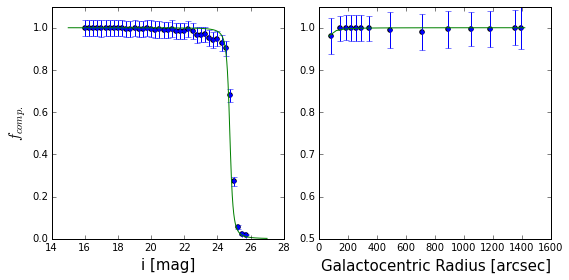

In [965]:
plt.figure(figsize=(8,4))
plt.subplot(121)

plt.scatter(Bins[1:], completeness_frac[1:])
plt.xlabel('i [mag]', size=15)
plt.ylabel('$f_{comp.}$', size=15)
plt.ylim(0,1.1)
plt.errorbar(Bins[1:], completeness_frac[1:],xerr=0,yerr=(np.true_divide(np.sqrt(SSEX_B[1:]),HST_B[1:])), fmt='.')
plt.plot(P_points, Pritchet_f(P_points,24.75,5))
#.savefig(filename_comp[:-5]+'_Mag_completeness_I.png')
print np.true_divide(np.sqrt(SSEX_B[1:]),HST_B[1:])
#HST_B
#SSEX_B


plt.subplot(122)

plt.scatter(Bins_Dist_i, completeness_frac_Dist_i)
plt.xlabel('Galactocentric Radius [arcsec]', size=15)
plt.errorbar(Bins_Dist_i, completeness_frac_Dist_i,xerr=0, yerr=(np.true_divide(np.sqrt(SSEX_Dist_i),HST_Dist_i)), fmt='.')
#plt.ylabel('$i f_{comp.}$', size=15)
#plt.xlim(0,500)
plt.ylim(0.9,1.05)

#plt.xticks(Bins_Dist_i,)
plt.plot(R_P_points, Pritchet_f(R_P_points/50,0.005,-2.5))
#plt.savefig(filename[:-5]+'_GDist_completenessI.png')
#plt.yticks([1,0.9],[1,0.9])
plt.ylim(0.5,1.05)
plt.tight_layout()
plt.savefig('completeness_Subaru.png')
plt.show()

# Define radial incompleteness function ofr surface density profile 
# Adjust for mag incompleteness

ValueError: operands could not be broadcast together with shapes (14505,) (14403,) 

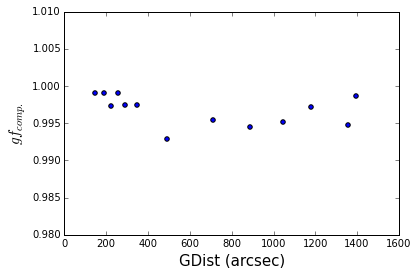

In [966]:
# is it posible to adjust for magnitude incompleteness to establish an overall fraction to multiply radial incompleteness by ? 
# that is assuming we have an even spread of all magnitudes over all radii 
# not very accurate or elegant but not sure how i would transfer the magnitude completeness to radial incompleteness otherwise


#offset from mag completeness

#print 1-XXXG, 1-XXXR, 1-XXXI # doesn't work due to unequal binning

plt.scatter(Bins_Dist[1:], completeness_frac_Dist[1:])
plt.xlabel('GDist (arcsec)', size=15)
plt.ylabel('$g f_{comp.}$', size=15)
#plt.xlimD_RA=comp['col2_1'][(comp['col1_1']=='g')&(comp['col4_1']<=23)&(comp['col4_1']>=19)]-6288.1837
D_DEC=comp['col3_1'][(comp['col1_1']=='g')&(comp['col4_1']<=23)&(comp['col4_1']>=19)]-5775.7879

D_RA_r=comp['col2_1'][(comp['col1_1']=='r')&(comp['col4_1']<=23)&(comp['col4_1']>=19)]-6281.2293
D_DEC_r=comp['col3_1'][(comp['col1_1']=='r')&(comp['col4_1']<=23)&(comp['col4_1']>=19)]-5743.8101

D_RA_i=comp['col2_1'][(comp['col1_1']=='i')&(comp['col4_1']<=23)&(comp['col4_1']>=19)]-6290.1076
D_DEC_i=comp['col3_1'][(comp['col1_1']=='i')&(comp['col4_1']<=23)&(comp['col4_1']>=19)]-5785.2218

D_HST_RA_g=comp_full['col2'][(comp_full['col1']=='g')&(comp_full['col4']<=23)&(comp_full['col4']>=19)]-6288.1837
D_HST_DEC_g=comp_full['col3'][(comp_full['col1']=='g')&(comp_full['col4']<=23)&(comp_full['col4']>=19)]-5775.7879

D_HST_RA_r=comp_full['col2'][(comp_full['col1']=='r')&(comp_full['col4']<=23)&(comp_full['col4']>=19)]-6281.2293
D_HST_DEC_r=comp_full['col3'][(comp_full['col1']=='r')&(comp_full['col4']<=23)&(comp_full['col4']>=19)]-5743.8101

D_HST_RA_i=comp_full['col2'][(comp_full['col1']=='i')&(comp_full['col4']<=23)&(comp_full['col4']>=19)]-6290.1076
D_HST_DEC_i=comp_full['col3'][(comp_full['col1']=='i')&(comp_full['col4']<=23)&(comp_full['col4']>=19)]-5785.2218


GDist= ((D_RA**2+D_DEC**2)**0.5)*(0.2)
GDist_r= ((D_RA_r**2+D_DEC_r**2)**0.5)*(0.2)
GDist_i= ((D_RA_i**2+D_DEC_i**2)**0.5)*(0.2)
GDist_HST_g= (((D_HST_RA_g)**2+(D_HST_DEC_g)**2)**0.5)*(0.2)
GDist_HST_r= (((D_HST_RA_r)**2+(D_HST_DEC_r)**2)**0.5)*(0.2)
GDist_HST_i= (((D_HST_RA_i)**2+(D_HST_DEC_i)**2)**0.5)*(0.2)

manual_distances = [4,128.98,167.94,204,237.8,270.3,312,477.6,711.6,888,1046,1181,1353.5]

distances = manual_distances#np.sort(GDist_HST_g)[0::550]
distances_r = manual_distances#np.sort(GDist_HST_r)[0::550]
distances_i = manual_distances#np.sort(GDist_HST_i)[0::550] # in this case HST describes the full sample of added objects on the subaru image



#Bins_Dist= np.arange(0,1500,50)
Bins_Dist= np.round(distances)
Bins_Dist_r= np.round(distances_r)
Bins_Dist_i= np.round(distances_i)

print distances_r

HST_DB= np.digitize(GDist_HST_g, Bins_Dist)
SSEX_DB= np.digitize(GDist,Bins_Dist)

HST_Dist = np.bincount(HST_DB)
SSEX_Dist = np.bincount(SSEX_DB)

###############
HST_DB_r= np.digitize(GDist_HST_r, Bins_Dist_r)
SSEX_DB_r= np.digitize(GDist_r,Bins_Dist_r)

HST_Dist_r = np.bincount(HST_DB_r)
SSEX_Dist_r = np.bincount(SSEX_DB_r)

##################
HST_DB_i= np.digitize(GDist_HST_i, Bins_Dist_i)
SSEX_DB_i= np.digitize(GDist_i,Bins_Dist_i)

HST_Dist_i = np.bincount(HST_DB_i)
SSEX_Dist_i = np.bincount(SSEX_DB_i)

################################
#not very accurate needs rewriting problems with 0!!
################################

if (len(HST_Dist)>len(SSEX_Dist)):
    SSEX_Dist=np.insert(SSEX_Dist,len(SSEX_Dist),0)
if len(HST_Dist)<len(SSEX_Dist):
    HST_Dist=np.insert(HST_Dist,len(HST_Dist),0)
else:
    print 'has the right shape'

if (len(HST_Dist_i)>len(SSEX_Dist_i)):
    SSEX_Dist_i=np.insert(SSEX_Dist_i,len(SSEX_Dist_i),0)
if len(HST_Dist_i)<len(SSEX_Dist_i):
    HST_Dist_i=np.insert(HST_Dist_i,len(HST_Dist_i),0)
else:
    print 'has the right shape'

if (len(HST_Dist_r)>len(SSEX_Dist_r)):
    SSEX_Dist_r=np.insert(SSEX_Dist_r,len(SSEX_Dist_r),0)
if len(HST_Dist_r)<len(SSEX_Dist_r):
    HST_Dist_r=np.insert(HST_Dist_r,len(HST_Dist_r),0)
else:
    print 'has the right shape'

print '#### g ####'
print HST_Dist
print SSEX_Dist

completeness_frac_Dist=np.true_divide(SSEX_Dist+0.0001,HST_Dist+0.0001)

if len(Bins_Dist)<len(completeness_frac_Dist):
    Bins_Dist=np.insert(Bins_Dist,len(Bins_Dist),max(Bins_Dist)-Bins_Dist[1]+Bins_Dist[2])
if len(Bins_Dist)>len(completeness_frac_Dist):
    print 'help'
    
    
print '#### r ####'
print HST_Dist_r
print SSEX_Dist_r


completeness_frac_Dist_r=np.true_divide(SSEX_Dist_r+0.0001,HST_Dist_r+0.0001)
if len(Bins_Dist_r)<len(completeness_frac_Dist_r):
    Bins_Dist_r=np.insert(Bins_Dist_r,len(Bins_Dist_r),max(Bins_Dist_r)-Bins_Dist_r[1]+Bins_Dist_r[2])
if len(Bins_Dist_r)>len(completeness_frac_Dist_r):
    print 'help'

    
print '#### i ####'
print HST_Dist_i
print SSEX_Dist_i

 
completeness_frac_Dist_i=np.true_divide(SSEX_Dist_i+0.0001,HST_Dist_i+0.0001)
if len(Bins_Dist_i)<len(completeness_frac_Dist_i):
    Bins_Dist_i=np.insert(Bins_Dist_i,len(Bins_Dist_i),max(Bins_Dist_i)-Bins_Dist_i[1]+Bins_Dist_i[2])
if len(Bins_Dist_i)>len(completeness_frac_Dist_i):
    print 'help'




R_P_points= np.arange(80,max(Bins_Dist),50)
plt.figure()


plt.scatter(Bins_Dist[1:], completeness_frac_Dist[1:])
plt.xlabel('GDist (arcsec)', size=15)
plt.ylabel('$g f_{comp.}$', size=15)
#plt.xlim(0,500)
#plt.ylim(0.5,1)
plt.plot(R_P_points, 1-Pritchet_f(R_P_points/50,0.005,1.3))
plt.savefig(filename[:-5]+'_GDist_completenessG.png')


plt.figure()


plt.scatter(Bins_Dist_r[1:], completeness_frac_Dist_r[1:])
plt.xlabel('GDist (arcsec)', size=15)
plt.ylabel('$r f_{comp.}$', size=15)
#plt.xlim(0,500)
#plt.ylim(0.5,1)
plt.plot(R_P_points, 1-Pritchet_f(R_P_points/50,0.005,1.3))
plt.savefig(filename[:-5]+'_GDist_completenessR.png')


plt.figure()


plt.scatter(Bins_Dist_i[1:], completeness_frac_Dist_i[1:])
plt.xlabel('GDist (arcsec)', size=15)
plt.ylabel('$i f_{comp.}$', size=15)
#plt.xlim(0,500)
#plt.ylim(0.5,1)
plt.plot(R_P_points, 1-Pritchet_f(R_P_points/50,0.005,1.3))
plt.savefig(filename[:-5]+'_GDist_completenessI.png')
plt.show()

# Mag incompleteness curves

In [967]:
comp_g = Pritchet_f(P_points,21.5,1)
comp_r= Pritchet_f(P_points,23,1)-0.08
comp_i= Pritchet_f(P_points,21.5,0.95)

comp_overall_g = np.true_divide(len(D_RA),len(D_HST_RA_g))
print comp_overall_g
comp_overall_r = np.true_divide(len(D_RA_r),len(D_HST_RA_r))
print comp_overall_r
comp_overall_i =np.true_divide(len(D_RA_i),len(D_HST_RA_i))
print comp_overall_i


p_overall_g = np.true_divide(len(comp_g),len(comp_g))
print 1-comp_overall_g
p_overall_r = np.true_divide(len(D_RA_r),len(comp_r))
print 1-comp_overall_r
p_overall_i =np.true_divide(len(comp_i),len(comp_i))
print 1-comp_overall_i

0.994514912581
0.976397401885
0.989777122859
0.00548508741858
0.0236025981155
0.0102228771413


# change of mean colour


In [684]:
# mean colour in terms of randial bins 

#make radial bins

#bin colour in terms of radius

#determin mean colour in each bin 

D_RA=N4526['ALPHA_J2000_3']-188.51262
D_DEC=N4526['DELTA_J2000_3']-7.6991162
q=0.43
D_RA_sub=Subaru_comp['ALPHA_J2000_3']-188.51262
D_DEC_sub=Subaru_comp['DELTA_J2000_3']-7.6991162
RV_RA=RV['ALPHA_J2000_3']-188.51262
RV_DEC=RV['DELTA_J2000_3']-7.6991162

Dist= 16.4*(10**6)
GDist= ((D_RA**2+(D_DEC**2))**0.5)*(60**2)
GCD= ((q*D_RA**2+(D_DEC**2)/q)**0.5)*(60**2)
GCD_sub= (q*(D_RA_sub**2+(D_DEC_sub**2)/q)**0.5)*(60**2)
GDist_sub= ((D_RA_sub**2+(D_DEC_sub**2))**0.5)*(60**2)
Dist_RV=((RV_RA**2+(RV_DEC**2))**0.5)*(60**2)
GDist_RV= (q*(RV_RA**2+(RV_DEC**2)/q)**0.5)*(60**2)#plot mean colour vs mean value of radial bin 

[  53.68550513  111.312957    180.01347771  270.17576185  369.76210744
  490.70410496  584.05593691  671.21325158]
complete
best fit line:
y = nan + nanx
blue
best fit line:
y = 0.73 + 0.00x
red
best fit line:
y = 1.03 + 0.00x


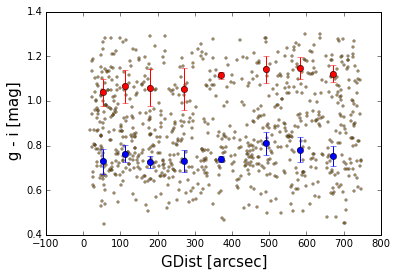

In [1031]:
red=(P1>0.5)
blue=(P2>0.5)

#DBins= np.sort(GDist_sub[selection_Subaru])[0::15]
#DBinsr= np.sort(GDist_sub[selection_Subaru][red])[0::50]
#DBinsb= np.sort(GDist_sub[selection_Subaru][blue])[0::100]

#bins_rad = np.digitize(GDist_sub[selection_Subaru],DBins)
#bins_rad_r = np.digitize(GDist_sub[selection_Subaru][red],DBinsr)
#bins_rad_b = np.digitize(GDist_sub[selection_Subaru][blue],DBinsr)#changed
#GI=Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru]
#GI_r=Subaru_comp[Gmag][selection_Subaru][red]-Subaru_comp[Imag][selection_Subaru][red]
#GI_b=Subaru_comp[Gmag][selection_Subaru][blue]-Subaru_comp[Imag][selection_Subaru][blue]
#print bins_rad
#rad= []
color=[]
reds=[]
blues=[]
#for i in np.arange(1,np.max(bins_rad)+1,1):
    #color.append(np.mean(GI[bins_rad==i]))
    
#for i in np.arange(1,np.max(bins_rad_r)+1,1):
    #reds.append(np.mean(GI_r[bins_rad_r==i]))
    
#for i in np.arange(1,np.max(bins_rad_b)+1,1):
    #blues.append(np.mean(GI_b[bins_rad_b==i]))

    
med_blue=[0.73,0.764,0.726,0.731,0.741,0.810,0.781,0.753]#,0.743]#,0.665,0.776,0.711,0.782,0.711]
med_red=[1.038,1.065,1.058,1.054,1.114,1.141,1.148,1.122]#,1.119]#,1.009,1.068,1.061,1.123,1.03]
err_blue=[0.056,0.037,0.028,0.049,0.013,0.051,0.055,0.043]#,0.024]#,0.034,0.04,0.061,0.081,0.11]
err_red=[0.06,0.073,0.083,0.093,0.014,0.059,0.048,0.039]#,0.029]#,0.039,0.059,0.07,0.086,0.073]
bins_gc=np.sort(GDist_sub[selection_Subaru])[0::100]
bins_gc= bins_gc[:-1]+(bins_gc[2]-bins_gc[1])/2
print bins_gc
#print len (DBins)
span = np.arange(0,801,1)
plt.figure()
plt.scatter(GDist_sub[selection_Subaru],Subaru_comp[Gmag][selection_Subaru]-Subaru_comp[Imag][selection_Subaru], c='orange', s=5, alpha =0.5)
#plt.scatter(DBinsr,blues, color='b')
plt.scatter(bins_gc,med_blue, color='blue')
plt.errorbar(bins_gc,med_blue,xerr=0, yerr=err_blue, color='blue', fmt='o')
#plt.axhspan(0.74,0.741 , color='blue')
#plt.scatter(DBinsr,reds,color='r')
plt.scatter(bins_gc,med_red, color='red')
plt.errorbar(bins_gc,med_red,xerr=0, yerr=err_red, color='red', fmt='o')
#plt.axhspan(1.05,1.051 , color='red')
plt.xlabel('GDist [arcsec]', size=15)
plt.ylabel(' g - i [mag]', size =15)
print 'complete'
best_fit(DBins,color)
print 'blue'
best_fit(bins_gc,med_blue)
print 'red'
best_fit(bins_gc,med_red)
plt.savefig('Colour_gradient.png')
plt.show()

# Blue tilt

In [1032]:
from numpy import append

# Radial surface density (needs completeness first)

In [1033]:
blue_bins=[]
red_bins=[]
###############before doing this reset the initial arangement starting point to 0 !!!

##need a better sytem the division seems unreliable.....

for i in np.arange(2,len((P1)),1):
    if (np.nansum(np.round(P1)[:i])%50)== 0:
        blue_bins.append(i)   
print blue_bins

for i in np.arange(1,len((P1)),1):
    if (np.nansum(np.round(1-P1)[:i])%50)== 0:
        red_bins.append(i)   
print red_bins

[139, 140, 314, 315, 316, 317, 318, 475, 476, 477, 478, 651, 652, 653, 654, 655, 808, 809, 810]
[1, 82, 83, 153, 213, 287, 288, 371, 436, 519, 582, 649, 722, 793]


In [ ]:
selection_Subaru_full =(0.25<=(Subaru_comp[Gmag]-Subaru_comp[Rmag]))&((Subaru_comp[Gmag]-Subaru_comp[Rmag])<=0.75)&(Subaru_comp[Imag]<23)&(Subaru_comp[Imag]>19)&(Subaru_comp[Gmag]<30)&(Subaru_comp[Gmag]>0)&(Subaru_comp[Rmag]<30)&(Subaru_comp[Rmag]>0)&(0.45<=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&(1.3>=(Subaru_comp[Gmag]-Subaru_comp[Imag]))&(Subaru_comp['CLASS_STAR_3']>=0.5)&(Subaru_comp['CLASS_STAR_3']>Pritchet_f(Subaru_comp[Imag], 24.5, 0.65))&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)

#DBins= np.array([1,1.25,1.5,1.75,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]) 
#np.sort(GDist_sub[selection_Subaru_full])[50::50]
DBins=np.arange(1,18,1)


########################################
#selection_comp =(0.25<=(N4526[Gmag]-N4526[Rmag]))&((N4526[Gmag]-N4526[Rmag])<=0.75)&(N4526['zmag']<30)&(N4526['zmag']>0)&(N4526[Imag]<23.5)&(N4526[Imag]>19)&(N4526[Gmag]<30)&(N4526[Gmag]>0)&(N4526[Rmag]<26)&(N4526[Rmag]>0)&(0.45<=(N4526[Gmag]-N4526[Imag]))&(1.3>=(N4526[Gmag]-N4526[Imag]))&(N4526['CLASS_STAR_3']>=0.5)&(N4526['CLASS_STAR_3']>Pritchet_f(N4526[Imag], 24.5, 0.65))&(GDist<=800)#&(N4526['FWHM_IMAGE_3']<=4.1)&((N4526[Rmag]-N4526[Imag])<=0.55)&((N4526[Rmag]-N4526[Imag])>=0.2)#&(GDist<=9.5)


#######################################
#Rings = 50
#Area_full= np.arange(0.1,1500,Rings) # the area from galactic center outwards in arcsec**2 using the rings as areas to determine surface density over equal areas
Area = (DBins[:-1])**2 * np.pi
#DBins= np.sqrt(Area_full)/np.pi 


plt.figure()
n,bins,patches = plt.hist(GDist_sub[selection_Subaru_full]/60, bins=DBins)
nr,rbins,patchesr = plt.hist((GDist_sub[selection_Subaru ]/60),weights = P1, bins=DBins)
nb,bbins,patchesb = plt.hist((GDist_sub[selection_Subaru ]/60),weights = np.array(P2), bins=DBins)
print n
plt.close()

# instead of the histograms take P1 and 1-Pi and sum it to get total number of GCs 
# how to adjust binning ? 
# every time sum (P1) is a multible of 30 


t=[]
b=[]
r=[]
Area_rings =[]
for x in np.arange(1,len(n)+1,1):#,np.arange(0,len(nr),1),np.arange(0,len(nb),1)):
    t.append(np.sum(n[:x]))
    
for x in np.arange(1,len(nb)+1,1):
    b.append(np.sum(nb[:x]))
    
for x in np.arange(1,len(nr)+1,1):
    r.append(np.sum(nr[:x]))

#Area_rings.append(Area[0])
for i in np.arange(0,len(Area),1):
    if i == 0:
        Area_rings.append(Area[i])
    elif i > 0:
        Area_rings.append(Area[i]-Area[i-1])
    #print np.round(Area[i]), np.round(Area[i-1]), np.round(Area_rings)

Re = 0.3        
index = 0.5
bn = 1.9992*index - 0.3271
bg = 1.6

Nr_dense =[]
Nr_r_dense=[]
Nr_b_dense=[]
error_sd=[]
error_sd_r=[]
error_sd_b=[]
#surface_density= n/Area_rings 
surface_density=[]
surface_densityr=[]
surface_densityb=[]
# r, Arear
for i in np.arange(0,np.round(max(DBins[:-1])),1):
    #if DBins[:-1][i]>=12:
    if i >15:
        R_max = 120#subtract corners that have not been covered!!
        Area_extra = Area[i]-(R_max)
        
        surface_density.append(n[i]/(R_max))
        #Nr_dense.append(Nr[i]/R_max)
        error_sd.append(np.sqrt(n[i])/R_max)
        
        surface_densityr.append(nr[i]/(R_max))
        #Nr_r_dense.append(Nr_r[i]/R_max)
        error_sd_r.append(np.sqrt(nr[i])/R_max)
        
        surface_densityb.append(nb[i]/(R_max))
        #Nr_dense.append(Nr[i]/R_max)
        error_sd_b.append(np.sqrt(nb[i])/R_max)
        
        print surface_density[i]
        
    if i == 15:
        R_max = 80
        Area_extra = Area[i]-(R_max)#(R_max-DBins[:-1][i])**2*np.pi*20
        Area_real = Area[i]-Area_extra
        surface_density.append(n[i]/(Area_real))
        Nr_dense.append(Nr[i]/Area_rings[i])
        error_sd.append(np.sqrt(n[i])/Area_real)
        
        surface_densityr.append(nr[i]/(Area_real))
        #Nr_dense.append(Nr[i]/Area_rings[i])
        error_sd_r.append(np.sqrt(nr[i])/Area_real)
        
        surface_densityb.append(nb[i]/(Area_real))
        #Nr_dense.append(Nr[i]/Area_rings[i])
        error_sd_b.append(np.sqrt(nb[i])/Area_real)
        
    elif i <= 14:
        surface_density.append(n[i]/Area_rings[i])
        Nr_dense.append(Nr[i]/Area_rings[i])
        error_sd.append(np.sqrt(n[i])/Area_rings[i])
        
        surface_densityr.append(nr[i]/Area_rings[i])
        #Nr_dense.append(Nr[i]/Area_rings[i])
        error_sd_r.append(np.sqrt(nr[i])/Area_rings[i])
        
        surface_densityb.append(nb[i]/Area_rings[i])
        #Nr_dense.append(Nr[i]/Area_rings[i])
        error_sd_b.append(np.sqrt(nb[i])/Area_rings[i])
        #print n[i], Area_rings[i]
        #print surface_density[i]
Nr = surface_density**(-bn*(((DBins[:-1]+0.5/Re)**(1/index))-1))+bg


plt.figure(1, figsize=(7,5))
plt.scatter(np.log10(DBins[:-1]+0.5),np.log10(surface_density), color='g')
#plt.plot(np.log10(DBins[:-1]+0.5), np.log10(Nr))
#plt.ylim(-0.5,3)
plt.errorbar(np.log10(DBins[:-1]+0.5),np.log10(surface_density),xerr=0, yerr=np.log10(error_sd), color='green', fmt='.')
plt.scatter(np.log10(DBins[:-1]+0.5),np.log10(surface_densityr), color='r')
plt.errorbar(np.log10(DBins[:-1]+0.5),np.log10(surface_densityr),xerr=0, yerr=np.log10(error_sd_r), color='red', fmt='.')
plt.scatter(np.log10(DBins[:-1]+0.5),np.log10(surface_densityb), color='b')
plt.errorbar(np.log10(DBins[:-1]+0.5),np.log10(surface_densityb),xerr=0, yerr=np.log10(error_sd_b), color='blue', fmt='.')

#plt.scatter(np.log10(DBinsr/60),np.log10(red_bins), color='r') 
#plt.scatter(np.log10(DBinsb/60),np.log10(blue_bins), color='b')
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('log N$_{GC}$  [arcmin$^{-2}$]', size=15)
plt.xlabel('log R [arcmin]', size =15)
plt.savefig('surface_density.png')


print nr 
print nb

surface_density_cum= t/Area #replace with t for summed GC values over distance
#print surface_density, DBins[:-1][12]

#surface_densityr= red_bins/Arear
surface_densityr_cum= r/Area
#surface_densityb= blue_bins/Areab
surface_densityb_cum= b/Area
#print DBins
plt.figure(2, figsize=(7,5))
plt.scatter(np.log10(DBins[:-1]),np.log10(surface_density_cum), color='g')
plt.scatter(np.log10(DBins[:-1]),np.log10(surface_densityr_cum), color='r')
plt.scatter(np.log10(DBins[:-1]),np.log10(surface_densityb_cum), color='b')

plt.ylabel('log N$_{GC}$  [arcmin$^{-2}$]', size=15)
plt.xlabel('log R [arcmin]', size =15)
plt.savefig('surface_density_cumulative.png')
plt.show()

#Rings = 80
Area_full= np.arange(5,1500,Rings) # the area from galactic center outwards in arcsec**2 using the rings as areas to determine surface density over equal areas
#Area = (DBins[:-1])**2 * np.pi
DBins= np.sqrt(Area_full)/np.pi 
print np.round(DBins)

plt.figure()
n,bins,patches = plt.hist(GDist_sub[selection_Subaru_full]/60, bins=DBins)
nr,rbins,patchesr = plt.hist((GDist_sub[selection_Subaru ]/60),weights = P1, bins=DBins)
nb,bbins,patchesb = plt.hist((GDist_sub[selection_Subaru ]/60),weights = np.array(P2), bins=DBins)
print len(nr)
plt.close()

#instead of the histograms take P1 and 1-Pi and sum it to get total number of GCs 
#how to adjust binning ? 
#every time sum (P1) is a multible of 30 

print n

t=[]
b=[]
r=[]
Area_rings =[]
for x in np.arange(1,len(n)+1,1):#,np.arange(0,len(nr),1),np.arange(0,len(nb),1)):
    t.append(np.sum(n[:x]))
    
for x in np.arange(1,len(nb)+1,1):
    b.append(np.sum(nb[:x]))
    
for x in np.arange(1,len(nr)+1,1):
    r.append(np.sum(nr[:x]))

#Area_rings.append(Area[0])
for i in np.arange(0,len(Area_full),1):
    if i == 0:
        Area_rings.append(Area_full[i])
    elif i > 0:
        Area_rings.append(Area_full[i]-Area_full[i-1])
    #print np.round(Area[i]), np.round(Area[i-1]), np.round(Area_rings)

    
print Area_rings
surface_density= n/Area_rings[:-1]    
#r, Arear
#for i in np.arange(0,len(DBins)-1,1):
    #if DBins[:-1][i]>=22.5:    
        #surface_density.append(2*n[i]/Area_rings[i])
    #else :
        #surface_density.append(n[i]/Area_rings[i])
        

#replace with t for summed GC values over distance

#surface_densityr= red_bins/Arear
surface_densityr= nr/Rings
#surface_densityb= blue_bins/Areab
surface_densityb= nb/Rings
#print DBins
plt.figure(1, figsize=(7,5))
plt.scatter(np.log10(DBins[:-1]),np.log10(surface_density), color='g')
#plt.errorbar(np.log10(DBins[:-1]),np.log10(surface_density),xerr=0, yerr=np.log10(np.sqrt(surface_density)), color='green', fmt='o')
#plt.scatter(np.log10(DBins[:-1]),np.log10(surface_densityr), color='r')
#plt.scatter(np.log10(DBins[:-1]),np.log10(surface_densityb), color='b')


#plt.scatter(np.log10(DBinsr/60),np.log10(red_bins), color='r') 
#plt.scatter(np.log10(DBinsb/60),np.log10(blue_bins), color='b')
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('log N$_{GC}$  [arcmin$^{-2}$]', size=15)
plt.xlabel('log R [arcmin]', size =15)
plt.savefig('surface_density_equal_areas.png')



In [ ]:
%pwd

In [569]:
print DBins[13]

14


In [703]:
(GDist_sub[selection_Subaru])*(0.99-P1)

array([  4.46272963e+01,   7.07407031e+02,   5.86319441e+02,
         7.29592187e+00,  -3.63335951e+00,   1.18740917e+02,
         7.36306740e+02,   3.73059465e+01,   6.66639204e+02,
         0.00000000e+00,   1.62612002e+01,   2.53054322e+01,
         6.85294125e+02,   1.27454538e+02,   1.39948080e+02,
         9.35834632e+01,   5.89424815e+02,   2.85612792e+02,
         7.32056385e+02,   7.24040960e+02,   6.19298848e+02,
         6.48294419e+02,   5.92499182e+02,   5.89676796e+02,
        -4.45835356e+00,   5.89166882e+02,   5.81680520e+02,
         6.90055045e+02,  -4.17617125e+00,   5.70054061e+02,
         6.64446535e+02,   5.45262172e+02,   6.58109448e+02,
         5.53760682e+02,   5.56374123e+02,   5.66928710e+02,
         5.42426311e+02,   5.02823089e+02,   2.12295219e+01,
         5.25327988e+02,  -2.83586419e+00,   1.73211226e+01,
         6.89481820e+02,   5.88316554e+01,   6.20834508e+02,
        -1.69999397e+00,   6.13579307e+02,   7.13349427e+02,
         4.97358669e+02,